In [1]:
from bs4 import BeautifulSoup
import requests
import json
import pandas as pd
from lxml import etree
# from urllib.request import urlopen
# from requests.exceptions import Timeout
import sqlite3
from sqlite3 import Error
import re
# from pprint import pprint
# import logging
# import logging.config
from pandas import json_normalize
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import warnings
import squarify
from datetime import timedelta
if not sys.warnoptions:
       warnings.simplefilter("ignore")


# Анализ активности игроков в турнирах серии "Titled Tuesday"

Турниры Titled Tuesday - еженедельные турниры на сайте chess.com, в которых принимают участие шахматисты со всего мира, 
имеющие подтвержденное шахматное звание.

## Парсинг и сохранение

In [2]:
# парсинг главной страницы с информацией о турнире
# хотим достать список линков турниров за период 2016 - 2024
# парсим их с каждой страницы "tournaments_page_link"

tournaments_page_link = 'https://www.chess.com/tournament/live/titled-tuesdays?&page='
api_endpoint = "https://api.chess.com/pub/tournament/"
game_archives_link = "https://api.chess.com/pub/player/{username}/games/{YYYY}/{MM}"


PAGE_LINK = 'https://www.chess.com/news/view/published-data-api#pubapi-clients'

HEADERS = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) \
           AppleWebKit/537.36 (KHTML, like Gecko) Chrome/121.0.0.0 Safari/537.36'}
tournaments_class = "tournaments-live-name"
tournaments = []
num_pages = 16

def getTournamentData(tournaments_page_link):
    for el in range(1, num_pages):
        response = requests.get(tournaments_page_link + str(el), headers=HEADERS, timeout = 20)
        soup = BeautifulSoup(response.content, 'lxml')
        tmt_pages = soup.findAll('a', attrs= {tournaments_class})
        tournaments.append([link.attrs['href'] for link in tmt_pages])
    return tournaments


In [3]:
# функция чтения json

def getAPIData(api_link):
    try:
        response = requests.get(api_link, headers = HEADERS, timeout = 20)
        # print(response)
        json_output = response.json()
        # pprint(response.json())
        # print('-'*80)
    except Exception as e:
        # logfile.write(f'Ошибка чтения {e}')
        print(f'Ошибка чтения {e}')
    return json_output

In [4]:
# функция экспорта json по списку линков

def getSectionJson(url_list):
    json_outputs = []
    for el in url_list:
        json_output = getAPIData(el)
        json_outputs.append(json_output)
        # if response.status_code == 200:
        #     print('ok')
        # elif response.status_code != 200:
        #     print('not ok')
    return json_outputs

In [5]:
# итерируемся по списку списков, парсим "хвосты" url-линков, чтобы затем сформировать API линк (склеим атрибут api_endpoint)

tails = []

def getTailLinks(pages):
    for t_page in pages:
        for el in t_page:
            match = re.search(r'([A-Za-z]+-[A-Za-z]+-[A-Za-z]+-[A-Za-z]+-[A-Za-z]+-[0-9]+-[0-9]+-[0-9]+'
                '|[A-Za-z]+-[A-Za-z]+-[A-Za-z]+-[A-Za-z]+-[0-9]+-[0-9]+-[A-Za-z]+-[0-9]+'
                '|[A-Za-z]+-[A-Za-z]+-[A-Za-z]+-[A-Za-z]+-[0-9]+-[0-9]+-[0-9]+'
                '|-[A-Za-z]+-[A-Za-z]+-[A-Za-z]+-[A-Za-z]+-[A-Za-z]+-[A-Za-z]+-[0-9]+'
                '|-[A-Za-z]+-[A-Za-z]+-[A-Za-z]+-[A-Za-z]+-[0-9]+'
                '|-[A-Za-z]+-[A-Za-z]+-[0-9]+-[A-Za-z]+-[0-9]+'
                '|-[A-Za-z]+-[A-Za-z]+-[0-9]+-[A-Za-z]+-[A-Za-z]+-[0-9]+'
                '|[A-Za-z]+-[A-Za-z]+-[0-9]+-[A-Za-z]+-[0-9]+'
                '|-[A-Za-z]+-[A-Za-z]+-[A-Za-z]+-[0-9]+'
                '|-[A-Za-z]+-[0-9]+-[A-Za-z]+-[A-Za-z]+-[0-9]+-[A-Za-z]+-[0-9]+)',el)
            # print(match.group())
            if match is not None:
                # print(match, el)
                tails.append(match.group())
    return tails

In [6]:
# запись текста в файл

def write_parsed_text(file_name, input_attr):
    with open(file_name, mode='w') as w:
        w.writelines(
            input_attr
        )
        w.close()
    print('write completed')

In [7]:
# запись json результатов в отдельный файл

def write_parsed_json(file_name_2, input_attr):
    with open(file_name_2, mode='w') as w_2:
        w_2.writelines(
            json.dumps(input_attr, indent=2)
        )
        w_2.close()
    print('write completed')

In [8]:
# список линков турниров

tmt_pages = getTournamentData(tournaments_page_link)

In [9]:
tmt_pages

[['https://www.chess.com/tournament/live/late-titled-tuesday-blitz-march-05-2024-4605130',
  'https://www.chess.com/tournament/live/early-titled-tuesday-blitz-march-05-2024-4605129',
  'https://www.chess.com/tournament/live/late-titled-tuesday-blitz-february-27-2024-4590818',
  'https://www.chess.com/tournament/live/early-titled-tuesday-blitz-february-27-2024-4590817',
  'https://www.chess.com/tournament/live/late-titled-tuesday-blitz-february-20-2024-4576499',
  'https://www.chess.com/tournament/live/early-titled-tuesday-blitz-february-20-2024-4576498',
  'https://www.chess.com/tournament/live/late-titled-tuesday-blitz-february-13-2024-4576494',
  'https://www.chess.com/tournament/live/early-titled-tuesday-blitz-february-13-2024-4576493',
  'https://www.chess.com/tournament/live/late-titled-tuesday-blitz-february-06-2024-4547612',
  'https://www.chess.com/tournament/live/early-titled-tuesday-blitz-february-06-2024-4547611',
  'https://www.chess.com/tournament/live/late-titled-tuesday-

In [10]:
#  получили "хвосты"

tails = getTailLinks(tmt_pages)

In [11]:
# склеиваем с "хвосты" c api_endpoint
tt_api_urls = []

for el in tails:
    tt_api_urls = [api_endpoint + el for el in tails]
tt_api_urls


['https://api.chess.com/pub/tournament/late-titled-tuesday-blitz-march-05-2024-4605130',
 'https://api.chess.com/pub/tournament/early-titled-tuesday-blitz-march-05-2024-4605129',
 'https://api.chess.com/pub/tournament/late-titled-tuesday-blitz-february-27-2024-4590818',
 'https://api.chess.com/pub/tournament/early-titled-tuesday-blitz-february-27-2024-4590817',
 'https://api.chess.com/pub/tournament/late-titled-tuesday-blitz-february-20-2024-4576499',
 'https://api.chess.com/pub/tournament/early-titled-tuesday-blitz-february-20-2024-4576498',
 'https://api.chess.com/pub/tournament/late-titled-tuesday-blitz-february-13-2024-4576494',
 'https://api.chess.com/pub/tournament/early-titled-tuesday-blitz-february-13-2024-4576493',
 'https://api.chess.com/pub/tournament/late-titled-tuesday-blitz-february-06-2024-4547612',
 'https://api.chess.com/pub/tournament/early-titled-tuesday-blitz-february-06-2024-4547611',
 'https://api.chess.com/pub/tournament/late-titled-tuesday-blitz-january-30-2024-

In [12]:
# запись списка линков в файл
write_parsed_json('titled_tuesday_api_urls.txt', tt_api_urls)

write completed


In [13]:
# получение данных JSON по всем турнирам и запись в файл

tt_info = getSectionJson(tt_api_urls)
write_parsed_json('titled_tuesday_details.txt', tt_info)

write completed


In [14]:
# создание датасета с полным списком игроков по каждому турниру и запись в файл
# список игроков берется из url api, указанного в атрибуте словаря 'rounds'. 
# получаем список списков url
# полный список игроков берется из url, формируемого из tt_api_urls + '/11' (где 11 - это обозначение последнего раунда турнира)

tt_pl_links = []
for el in range(len(tt_api_urls)):
    # last_rnd_link = el+('/11')
    # tt_pl_links.append(last_rnd_link)
    last_rnd_url = getAPIData(tt_api_urls[el]).get('rounds')
    tt_pl_links.append(last_rnd_url)
write_parsed_json('tt_last_rnd_urls.txt', tt_pl_links)

write completed


In [15]:
# запишем распарсенные JSON данные списков игроков по турнирам в файл

tt_pl_list=[]
for el in tt_pl_links:
    for data in el:
        # urls_str = ''.join(el)
        tt_pl_list.append(getSectionJson([data]))
tt_pl_list
write_parsed_json('titled_tuesday_players_test.txt', tt_pl_list)

write completed


In [16]:
# # запишем распарсенные JSON данные списков абонентов по турнирам в файл

# tt_pl_list=[]
# for el in tt_pl_links:
#         urls_str = ''.join(el)
#         tt_pl_list.append(getSectionJson([urls_str]))
# tt_pl_list
# write_parsed_json('titled_tuesday_players_test.txt', tt_pl_list)

In [17]:
# добавление строк для будущего датафрейма: имеем dicts in list
# вытаскиваем ключи 'players' и 'groups'. Попутно конвертируем список в строку

rows = []
for el in tt_pl_list:
    for data in el:
        data_row = data['players']
        # time = data['groups']
        # time = (''.join(data['groups'])).replace('/1', '')
        time = (''.join(data['groups']))
        for row in data_row:
            row['tournament_url'] = time
            rows.append(row)
 
# создаем датафрейм со списком игроков в каждом турнире
# избавляемся от окончаний "/11/1","/9/1" и пр. в значениях tournament_url
# далее этот атрибут будет использоваться в качестве внешнего ключа

df_tt_players = pd.DataFrame(rows)
df_tt_players['tournament_url'] = df_tt_players['tournament_url'].str.split(r'(\/\d{2}\/\d{1}$)|(\/\d{1}\/\d{1}$)').str[0]
df_tt_players.to_csv('df_tt_players.csv', index=True) 
df_tt_players.tail(5)

username                                     tournament_url
174057            pomoc  https://api.chess.com/pub/tournament/-titled-t...
174058     underdogchss  https://api.chess.com/pub/tournament/-titled-t...
174059       angry_serb  https://api.chess.com/pub/tournament/-titled-t...
174060          usurpov  https://api.chess.com/pub/tournament/-titled-t...
174061  alex_stripunsky  https://api.chess.com/pub/tournament/-titled-t...

In [19]:
# импорт профилей
df_prof = pd.read_csv('ALL/df_all_profiles.csv')
df_prof.head(2)

Unnamed: 0                                             avatar  player_id  \
0           0  https://images.chesscomfiles.com/uploads/v1/us...   18800602   
1           1  https://images.chesscomfiles.com/uploads/v1/us...   29499974   

                                         @id  \
0     https://api.chess.com/pub/player/123lt   
1  https://api.chess.com/pub/player/124chess   

                                     url           name  username title  \
0     https://www.chess.com/member/123lt    Tingjie Lei     123lt    GM   
1  https://www.chess.com/member/124chess  Дмитрий Хегай  124chess    GM   

   followers                               country  last_online      joined  \
0        139  https://api.chess.com/pub/country/CN   1703685878  1410059361   
1         77  https://api.chess.com/pub/country/RU   1709089367  1471316272   

    status  is_streamer  verified  league    location twitch_url  \
0  premium        False     False   Stone         NaN        NaN   
1  premium        False     False  Bronze  Красноярск        NaN   

                           players.stats.url  
0     https://api.chess.com/pub/player/123lt  
1  https://api.chess.com/pub/player/124chess

In [20]:
# добавляем инфо о титуле
df_tt_players = pd.merge(df_tt_players, df_prof[['username','title']], how = 'left', on='username')
df_tt_players

username                                     tournament_url  \
0                andrzej  https://api.chess.com/pub/tournament/late-titl...   
1                    gmg  https://api.chess.com/pub/tournament/late-titl...   
2          ukchessbomber  https://api.chess.com/pub/tournament/late-titl...   
3       danielnaroditsky  https://api.chess.com/pub/tournament/late-titl...   
4        musiccitymaster  https://api.chess.com/pub/tournament/late-titl...   
...                  ...                                                ...   
174057             pomoc  https://api.chess.com/pub/tournament/-titled-t...   
174058      underdogchss  https://api.chess.com/pub/tournament/-titled-t...   
174059        angry_serb  https://api.chess.com/pub/tournament/-titled-t...   
174060           usurpov  https://api.chess.com/pub/tournament/-titled-t...   
174061   alex_stripunsky  https://api.chess.com/pub/tournament/-titled-t...   

       title  
0         CM  
1         GM  
2         FM  
3         GM  
4         FM  
...      ...  
174057   WGM  
174058    GM  
174059    IM  
174060    FM  
174061    GM  

[174062 rows x 3 columns]

In [21]:
# формируем датафрейм с общей информацией о каждом турнире TT
# попутно конвертируем столбец rounds, который будет внешним ключом
# для других таблиц(это уникальная ссылка на api турнира): отсекаем значения после последнего слэша

df_tt_info = pd.json_normalize(tt_info)
df_tt_info['tournament_url'] = df_tt_info['rounds'].str[0].str.split(r'(\/\d{2}$)|(\/\d{1}$)').str[0]
df_tt_info.to_csv('df_tt_info.csv', index=True) 
df_tt_info.head(1)

name  \
0  Late-Titled-Tuesday-Blitz-March-05-2024   

                                                 url   creator    status  \
0  https://www.chess.com/tournament/live/late-tit...  CHESScom  finished   

   start_time  finish_time                                            players  \
0  1709676000   1709683567  [{'username': 'hikaru', 'status': 'winner'}, {...   

                                              rounds settings.type  \
0  [https://api.chess.com/pub/tournament/late-tit...         swiss   

  settings.rules  settings.is_rated  settings.is_official  \
0          chess               True                  True   

   settings.is_invite_only  settings.user_advance_count  \
0                    False                            1   

   settings.winner_places  settings.registered_user_count  \
0                       3                             502   

   settings.total_rounds settings.time_class settings.time_control  \
0                     11               blitz                 180+1   

                                      tournament_url  
0  https://api.chess.com/pub/tournament/late-titl...

In [22]:
df_tt_players.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174062 entries, 0 to 174061
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   username        174062 non-null  object
 1   tournament_url  174062 non-null  object
 2   title           168699 non-null  object
dtypes: object(3)
memory usage: 4.0+ MB


In [23]:
df_tt_info.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 375 entries, 0 to 374
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   name                            375 non-null    object
 1   url                             375 non-null    object
 2   creator                         375 non-null    object
 3   status                          375 non-null    object
 4   start_time                      375 non-null    int64 
 5   finish_time                     375 non-null    int64 
 6   players                         375 non-null    object
 7   rounds                          375 non-null    object
 8   settings.type                   375 non-null    object
 9   settings.rules                  375 non-null    object
 10  settings.is_rated               375 non-null    bool  
 11  settings.is_official            375 non-null    bool  
 12  settings.is_invite_only         375 non-null    bo

## Обработка датафреймов. Создаем основную таблицу для когортного анализа

In [24]:
# формируем временный датафрейм из двух исходных, 
# переименовываем столбцы, конвертируем unixtime в datetime, создаем поле tournament_id
# создаем поле game_id - уникальный идентификатор игры (аналог id транзакции)

df_temp = pd.merge(df_tt_players, df_tt_info, on='tournament_url')
df_temp.rename(columns={'name':'tournament_name'}, inplace = True)
df_temp.rename(columns={'settings.total_rounds':'games_count'}, inplace = True) 
df_temp.rename(columns={'settings.registered_user_count':'registered_user_count'}, inplace = True) 
df_temp['tournament_id'] = df_temp['url'].str.split('-').str[-1]
df_temp['game_id'] = df_temp[['username','tournament_id']].apply(lambda x: "-".join(x), axis =1)
df_temp['start_time'] = pd.to_datetime(df_temp['start_time'],unit='s')
df_temp['finish_time'] = pd.to_datetime(df_temp['finish_time'],unit='s')
df_temp.head(1)



username                                     tournament_url title  \
0  andrzej  https://api.chess.com/pub/tournament/late-titl...    CM   

                           tournament_name  \
0  Late-Titled-Tuesday-Blitz-March-05-2024   

                                                 url   creator    status  \
0  https://www.chess.com/tournament/live/late-tit...  CHESScom  finished   

           start_time         finish_time  \
0 2024-03-05 22:00:00 2024-03-06 00:06:07   

                                             players  ...  \
0  [{'username': 'hikaru', 'status': 'winner'}, {...  ...   

  settings.is_official settings.is_invite_only settings.user_advance_count  \
0                 True                   False                           1   

   settings.winner_places  registered_user_count  games_count  \
0                       3                    502           11   

   settings.time_class  settings.time_control  tournament_id          game_id  
0                blitz                  180+1        4605130  andrzej-4605130  

[1 rows x 24 columns]

In [25]:
# создаем результирующий датафрейм на основе временного, копируя только нужные атрибуты
# запишем в файл

df_tt_result = df_temp.filter(['username', 'title', 'tournament_name','tournament_id', 'game_id', 'start_time', 'finish_time', \
    'settings.registered_user_count', 'games_count', 'registered_user_count'])
df_tt_result.to_csv('df_tt_result.csv')
df_tt_result.tail(1)


username title               tournament_name tournament_id  \
174061  alex_stripunsky    GM  *** Titled Tuesday 3|2 Blitz        646318   

                       game_id          start_time         finish_time  \
174061  alex_stripunsky-646318 2016-04-05 18:00:00 2016-04-05 18:13:36   

        games_count  registered_user_count  
174061            9                    123

In [26]:
df_tt_result.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174062 entries, 0 to 174061
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   username               174062 non-null  object        
 1   title                  168699 non-null  object        
 2   tournament_name        174062 non-null  object        
 3   tournament_id          174062 non-null  object        
 4   game_id                174062 non-null  object        
 5   start_time             174062 non-null  datetime64[ns]
 6   finish_time            174062 non-null  datetime64[ns]
 7   games_count            174062 non-null  int64         
 8   registered_user_count  174062 non-null  int64         
dtypes: datetime64[ns](2), int64(2), object(5)
memory usage: 12.0+ MB


### Запишем результирующую табличку в БД

In [27]:
# функция для создания таблицы
sqlite_connection = sqlite3.connect('db_name')
def create_table(table_name, columns_list, path):
    query = 'CREATE TABLE IF NOT EXISTS {table} ({columns})'
    uni_query = query.format(table=table_name, columns = columns_list)
    db_name = '{t_name}.db'.format(t_name=path)
    try:
        sqlite_connection = sqlite3.connect(db_name)
        cursor = sqlite_connection.cursor()
        print('База данных создана и успешно подключена к SQLite')

        sqlite_select_query = 'select sqlite_version();'
        cursor.execute(uni_query)
        record = cursor.fetchall()
        print('Версия базы данныхх SQLite: ', record)
        cursor.close()
    except sqlite3.Error as error:
        print('Ошибка при подключении к SQLite', error)
    finally:
        if (sqlite_connection):
            sqlite_connection.close()
            print('Соединение с SQLite закрыто')

In [28]:
# функция создания подлючения к БД
def create_connection(path):
    connection = None
    try:
        connection = sqlite3.connect(path, timeout=10)
        print('Подключение к SQLite успешно')
    except Error as e:
        print(f"Произошла ошибка '{e}'")
    return connection

In [29]:
# Запись в БД
def write_sql_query(connection, query, table_name):
    cursor = connection.cursor()
    try:
        cursor.execute(query)
        connection.commit()
        df_tt_result.to_sql(table_name, connection, if_exists='replace', index = False)
        print("Query execution is successfull")
    except sqlite3.Error as error:
        print('Ошибка при подключении к SQLite', error)
    finally:
        if (sqlite_connection):
            sqlite_connection.close()
            print('Соединение с SQLite закрыто')
    cursor.execute(query)

In [30]:
# функция для чтения из БД
def read_sql_query(connection, query_read):
    cursor = connection.cursor()
    result = None
    try:
        cursor.execute(query_read)
        result = cursor.fetchall()
        return result
    except Error as e:
        print("f'Произошла ошибка {e}'")
    finally:
        if (sqlite_connection):
            sqlite_connection.close()
            print('Соединение с SQLite закрыто')

In [31]:
# создаем таблицу в БД
create_table('tt_result_table', 'username, title, tournament_name, tournament_id, game_id\
    start_time, finish_time, games_count, registered_user_count',\
        'tt_result_table')

База данных создана и успешно подключена к SQLite
Версия базы данныхх SQLite:  []
Соединение с SQLite закрыто


In [32]:
# подключаемся к БД
path = 'tt_result_table.db'
connection = create_connection(path)

Подключение к SQLite успешно


In [33]:
# пишем в данные в таблицу
# sqlite_connection = sqlite3.connect('db_name')
query_write = 'CREATE TABLE IF NOT EXISTS tt_result_table \
(username, title, tournament_name, tournament_id, game_id\
    start_time, finish_time, games_count, registered_user_count)'
table_name = 'tt_result_table'
write_sql_query(connection, query_write, table_name)

Query execution is successfull
Соединение с SQLite закрыто


In [34]:
# читаем из БД
query_read = '''SELECT * FROM tt_result_table'''
read_sql_query(connection, query_read)

Соединение с SQLite закрыто


[('andrzej',
  'CM',
  'Late-Titled-Tuesday-Blitz-March-05-2024',
  '4605130',
  'andrzej-4605130',
  '2024-03-05 22:00:00',
  '2024-03-06 00:06:07',
  11,
  502),
 ('gmg',
  'GM',
  'Late-Titled-Tuesday-Blitz-March-05-2024',
  '4605130',
  'gmg-4605130',
  '2024-03-05 22:00:00',
  '2024-03-06 00:06:07',
  11,
  502),
 ('ukchessbomber',
  'FM',
  'Late-Titled-Tuesday-Blitz-March-05-2024',
  '4605130',
  'ukchessbomber-4605130',
  '2024-03-05 22:00:00',
  '2024-03-06 00:06:07',
  11,
  502),
 ('danielnaroditsky',
  'GM',
  'Late-Titled-Tuesday-Blitz-March-05-2024',
  '4605130',
  'danielnaroditsky-4605130',
  '2024-03-05 22:00:00',
  '2024-03-06 00:06:07',
  11,
  502),
 ('musiccitymaster',
  'FM',
  'Late-Titled-Tuesday-Blitz-March-05-2024',
  '4605130',
  'musiccitymaster-4605130',
  '2024-03-05 22:00:00',
  '2024-03-06 00:06:07',
  11,
  502),
 ('themagician',
  'FM',
  'Late-Titled-Tuesday-Blitz-March-05-2024',
  '4605130',
  'themagician-4605130',
  '2024-03-05 22:00:00',
  '2024-0

# Когортный анализ

In [35]:
# connection = sqlite3.connect('tt_result_table.db', timeout=10)

df = pd.read_sql_query("SELECT * FROM tt_result_table", connection)
df.tail(1)

username title               tournament_name tournament_id  \
174061  alex_stripunsky    GM  *** Titled Tuesday 3|2 Blitz        646318   

                       game_id           start_time          finish_time  \
174061  alex_stripunsky-646318  2016-04-05 18:00:00  2016-04-05 18:13:36   

        games_count  registered_user_count  
174061            9                    123

In [36]:
print('В датафрейме {} строк и {} столбцов.'
      .format(df.shape[0], df.shape[1]))
print('Число транзакций с пустым идентификатором пользователя {:,}.'
      .format(df[df.username.isnull()].shape[0]))
print('В датасете предоставлены данные за период с {} до {}'.format(df['start_time'].min(),
                                    df['start_time'].max()))

В датафрейме 174062 строк и 9 столбцов.
Число транзакций с пустым идентификатором пользователя 0.
В датасете предоставлены данные за период с 2016-04-05 18:00:00 до 2024-03-05 22:00:00


In [37]:
# импорт таблицы из файла
# df = pd.read_csv('df_tt_result.csv')

In [38]:
df.describe();

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174062 entries, 0 to 174061
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   username               174062 non-null  object
 1   title                  168699 non-null  object
 2   tournament_name        174062 non-null  object
 3   tournament_id          174062 non-null  object
 4   game_id                174062 non-null  object
 5   start_time             174062 non-null  object
 6   finish_time            174062 non-null  object
 7   games_count            174062 non-null  int64 
 8   registered_user_count  174062 non-null  int64 
dtypes: int64(2), object(7)
memory usage: 12.0+ MB


In [40]:
df['start_time'] = pd.to_datetime(df_temp['start_time'],unit='s')
df['finish_time'] = pd.to_datetime(df_temp['finish_time'],unit='s')
df.head(5);

### Расчёт метрик

In [41]:
# уникальное число турниров
# num_tmts = len(pd.unique(df_tt_result['tournament_id']))
num_tmts = df['tournament_id'].nunique()
num_tmts

375

In [42]:
# число уникальных шахматистов, принимавших участие в турнирах "Titled Tuesday"

num_players = df['username'].nunique()
num_players

7556

In [43]:
# число уникальных турниров по шахматистам

num_games = df.groupby(['username'])['game_id'].nunique()
num_games.sort_values(ascending=False)

username
djano                   305
fairchess_on_youtube    299
tigrvshlyape            290
jospem                  290
mikhail_golubev         289
                       ... 
nnnneoooo                 1
i_like_kasparov           1
hypnopsycho               1
noghay                    1
zzzombie                  1
Name: game_id, Length: 7556, dtype: int64

In [44]:
# посчитаем число турниров на игрока

games_per_player = np.sum(num_games) / num_players
print('Число турниров на одного игрока равно {:.2f}.'.format(games_per_player))

Число турниров на одного игрока равно 23.04.


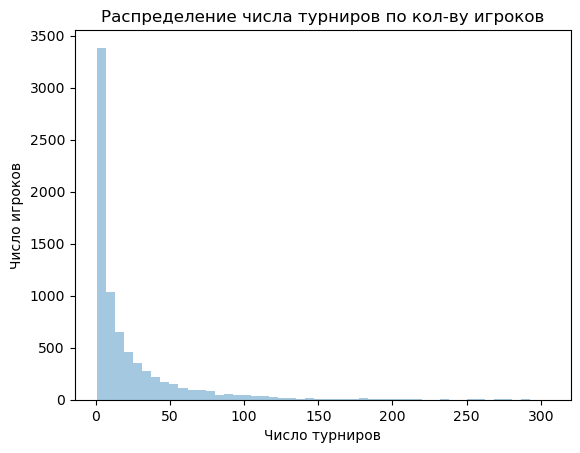

In [45]:
# график распределения числа турниров на игроков

ax = sns.distplot(num_games, kde=False, hist=True)
ax.set(title='Распределение числа турниров по кол-ву игроков',
       xlabel='Число турниров', 
       ylabel='Число игроков');

По графику видно, что большинство игроков принимало участие в менее чем 50 турнирах. Распределение не нормальное.

### Retention rate по месяцам

In [46]:
# создаем deep copy датафрейма df для анализа по месяцам
df_m = df.copy(deep=True)

In [47]:
# создаем атрибут game_month, который указывает месяц, когда игрок принимал участие в турнире
df_m['game_month'] = df_m['start_time'].dt.to_period('M')
df.head(1)

username title                          tournament_name tournament_id  \
0  andrzej    CM  Late-Titled-Tuesday-Blitz-March-05-2024       4605130   

           game_id          start_time         finish_time  games_count  \
0  andrzej-4605130 2024-03-05 22:00:00 2024-03-06 00:06:07           11   

   registered_user_count  
0                    502

In [48]:
# создаем атрибут cohort_month, который указывает на первый месяц, когда игрок принял участие в турнире серии TT
df_m['cohort_month'] = df_m.groupby('username')['game_month'].transform('min')
df_m.head(2)

username title                          tournament_name tournament_id  \
0  andrzej    CM  Late-Titled-Tuesday-Blitz-March-05-2024       4605130   
1      gmg    GM  Late-Titled-Tuesday-Blitz-March-05-2024       4605130   

           game_id          start_time         finish_time  games_count  \
0  andrzej-4605130 2024-03-05 22:00:00 2024-03-06 00:06:07           11   
1      gmg-4605130 2024-03-05 22:00:00 2024-03-06 00:06:07           11   

   registered_user_count game_month cohort_month  
0                    502    2024-03      2018-07  
1                    502    2024-03      2016-05

In [49]:
# выводим число месяцев с момента первой игры по сравнению с датой игры в конкретном турнире; формируем периоды
df_m['cohort_index'] = (df_m['game_month'] - df_m['cohort_month']).apply(lambda x: x.n)
df_m.head(2)

username title                          tournament_name tournament_id  \
0  andrzej    CM  Late-Titled-Tuesday-Blitz-March-05-2024       4605130   
1      gmg    GM  Late-Titled-Tuesday-Blitz-March-05-2024       4605130   

           game_id          start_time         finish_time  games_count  \
0  andrzej-4605130 2024-03-05 22:00:00 2024-03-06 00:06:07           11   
1      gmg-4605130 2024-03-05 22:00:00 2024-03-06 00:06:07           11   

   registered_user_count game_month cohort_month  cohort_index  
0                    502    2024-03      2018-07            68  
1                    502    2024-03      2016-05            94

In [50]:
# создаем датафрейм с агрегированными данными по первому месяцу игры и индексу; таким образом хотим проанализировать количество игроков,
# принимавших участие в турнире спустя определенное количество месяцев (индексы)
cohort_data_m = df_m.groupby(['cohort_month', 'cohort_index'])['username'].nunique().reset_index()
cohort_data_m

cohort_month  cohort_index  username
0         2016-04             0       137
1         2016-04             1        79
2         2016-04             2        59
3         2016-04             3        51
4         2016-04             4        55
...           ...           ...       ...
4451      2024-01             1        73
4452      2024-01             2        36
4453      2024-02             0       118
4454      2024-02             1        42
4455      2024-03             0        16

[4456 rows x 3 columns]

In [51]:
# активность игроков по месяцам
cohort_count_m = cohort_data_m.pivot_table(index='cohort_month', columns='cohort_index', values='username')
cohort_count_m.head(5)

cohort_index     0     1     2     3     4     5     6     7     8     9   \
cohort_month                                                                
2016-04       137.0  79.0  59.0  51.0  55.0  47.0  62.0  54.0  54.0  53.0   
2016-05       139.0  47.0  43.0  43.0  29.0  29.0  27.0  35.0  35.0  27.0   
2016-06        91.0  32.0  25.0  27.0  25.0  21.0  24.0  27.0  21.0  20.0   
2016-07        57.0  26.0  17.0  17.0  16.0  14.0  13.0  17.0  19.0  26.0   
2016-08        60.0  17.0  14.0  14.0  12.0  12.0  10.0  10.0  13.0   2.0   

cohort_index  ...    86    87    88    89    90    91    92    93    94    95  
cohort_month  ...                                                              
2016-04       ...  43.0  39.0  42.0  38.0  39.0  35.0  44.0  49.0  42.0  24.0  
2016-05       ...  33.0  32.0  33.0  37.0  23.0  25.0  36.0  28.0  17.0   NaN  
2016-06       ...  24.0  19.0  16.0  16.0  18.0  20.0  23.0  10.0   NaN   NaN  
2016-07       ...  14.0  10.0  12.0  11.0  15.0  12.0   4.0   NaN   NaN   NaN  
2016-08       ...  14.0  10.0   9.0  12.0  12.0   5.0   NaN   NaN   NaN   NaN  

[5 rows x 96 columns]

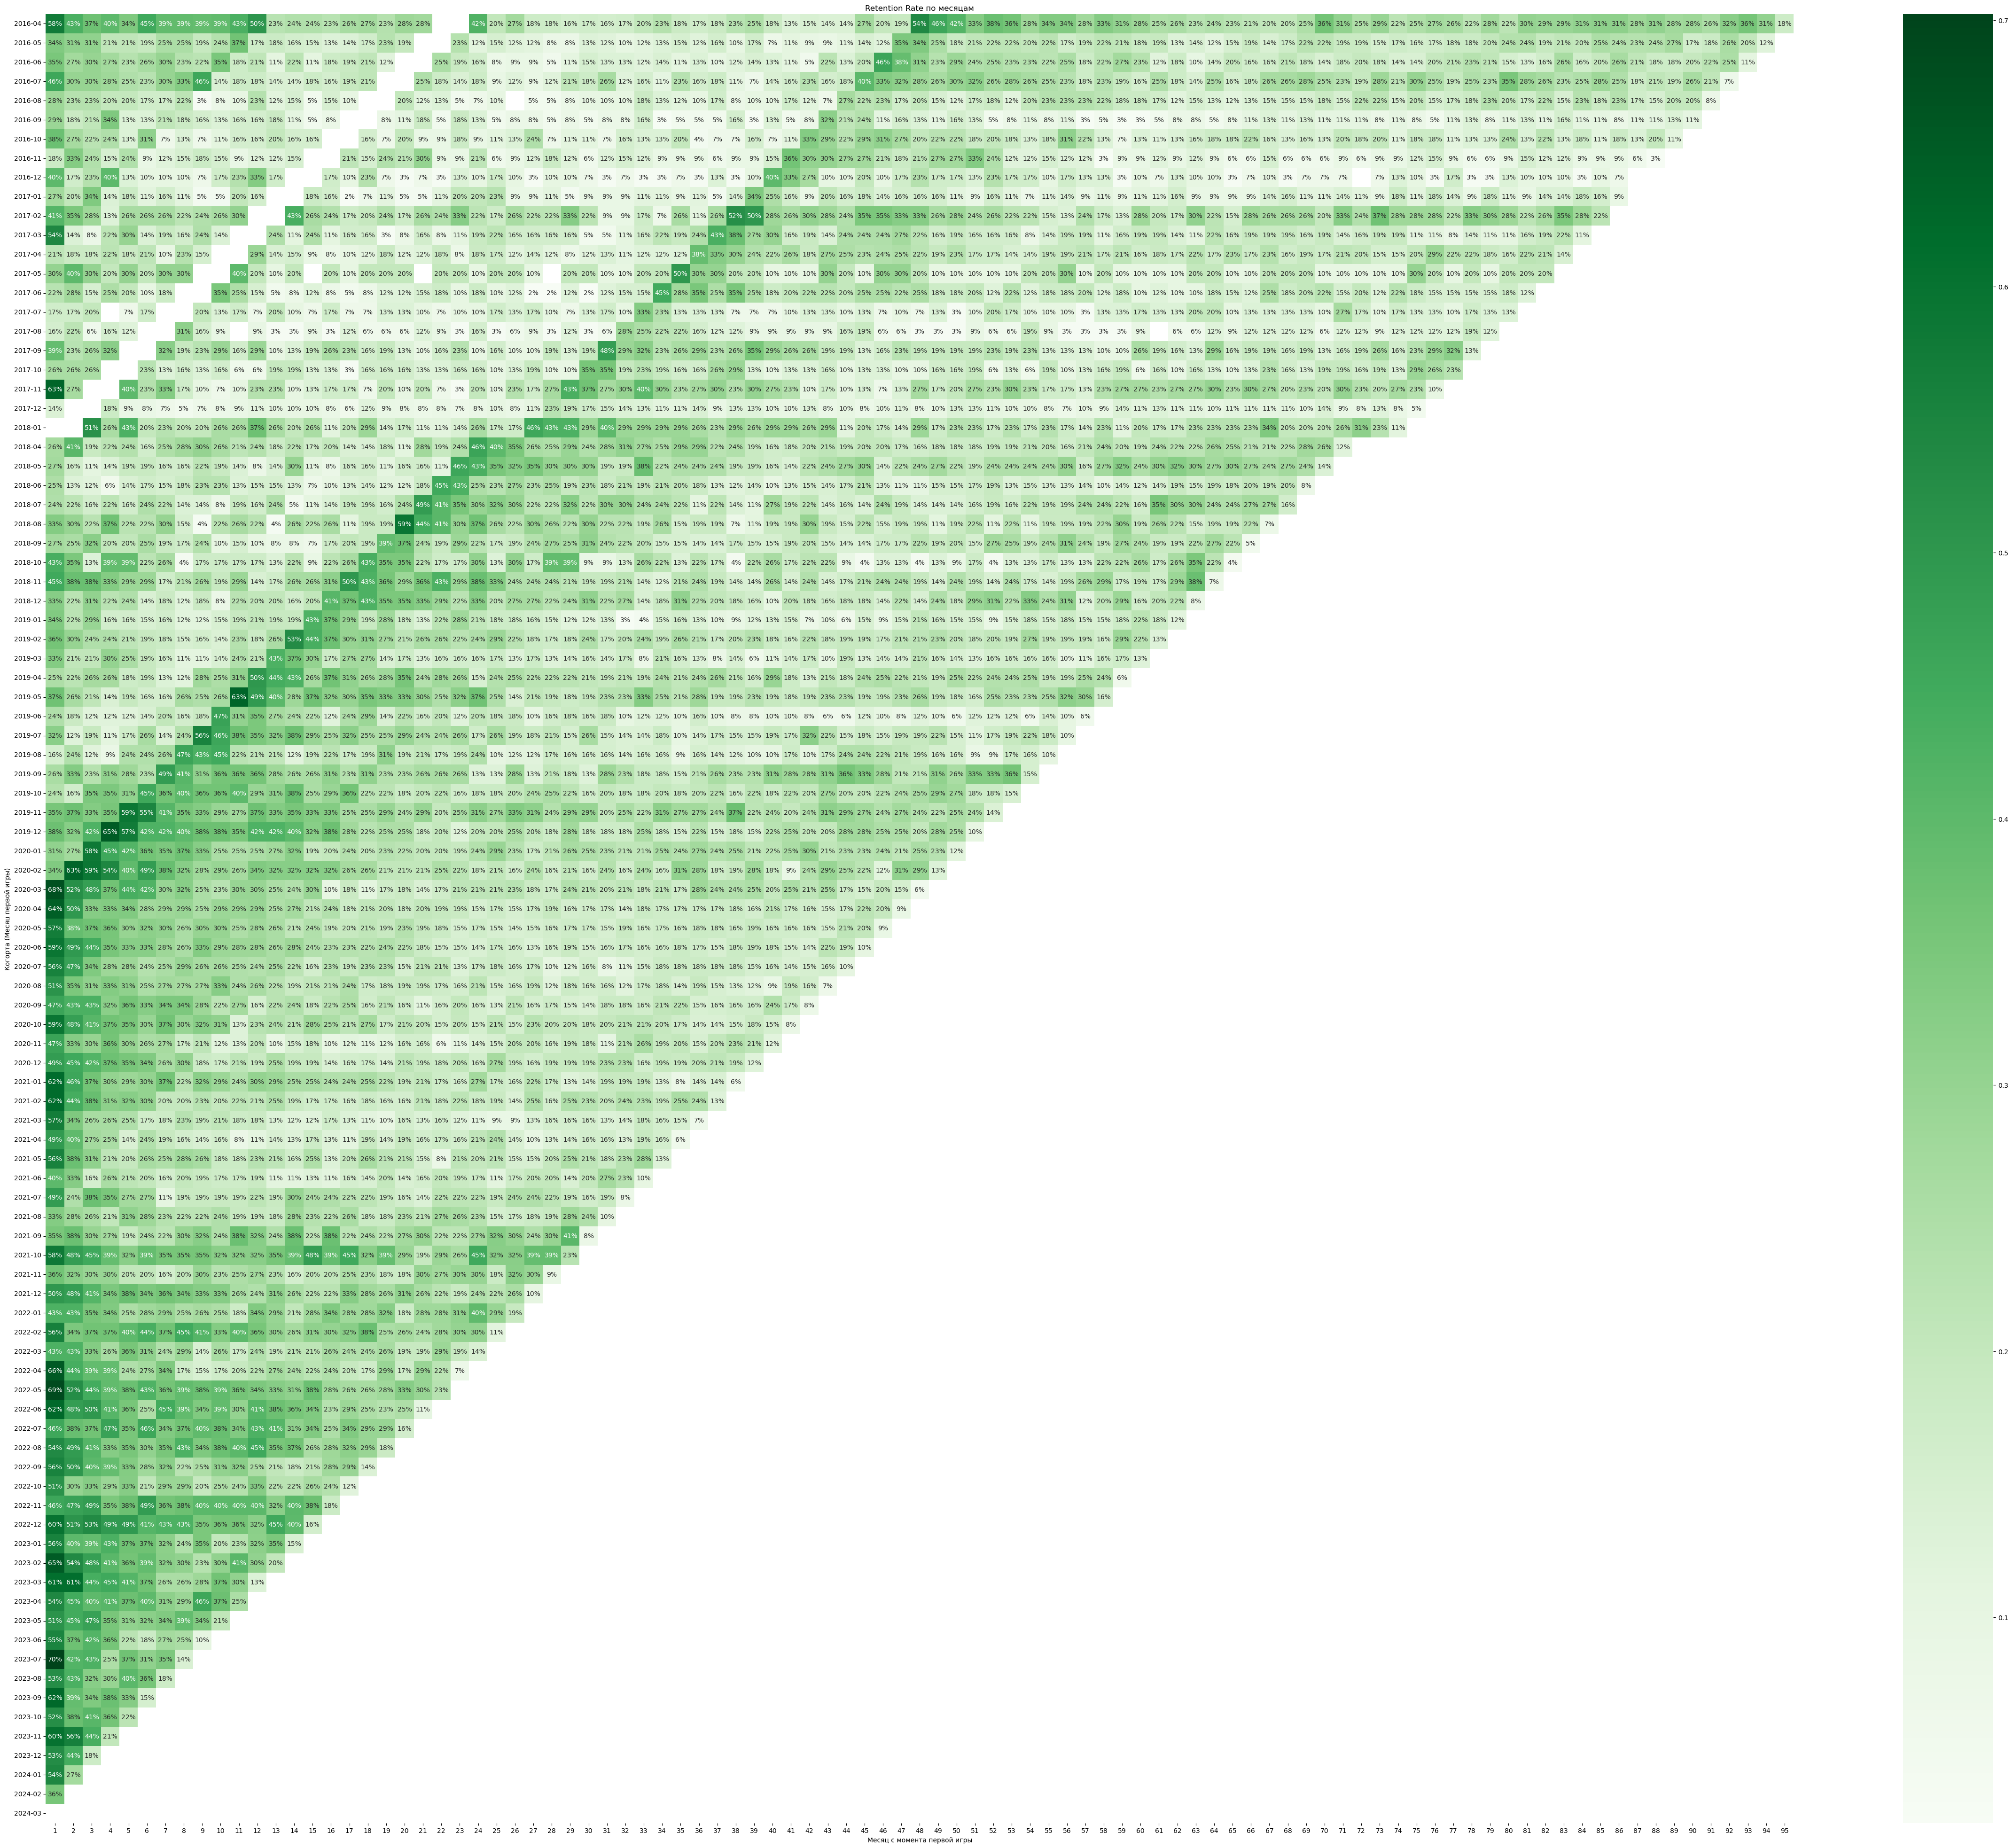

In [52]:
# Вычисление размера когорты
cohort_sizes_m = cohort_count_m.iloc[:,0]

# Вычисление Retention Rate
retention_m = cohort_count_m.divide(cohort_sizes_m, axis=0)

# Удаление первого столбца, так как он представляет размер когорты, а не Retention Rate
retention_m = retention_m.drop(columns=0)

# Визуализация Retention Rate с помощью тепловой карты
plt.figure(figsize=(60, 50))
sns.heatmap(retention_m, annot=True, fmt='.0%', cmap='Greens')
plt.title('Retention Rate по месяцам')
plt.ylabel('Когорта (Месяц первой игры)')
plt.xlabel('Месяц с момента первой игры')
plt.show()

In [53]:
# число уникальных турниров по месяцам

num_tmts = df_m.groupby(['game_month'])['tournament_id'].nunique()
num_tmts.sort_values(ascending=False);

# число уникальных игроков по месяцам
num_plrs = df_m.groupby(['game_month'])['username'].nunique()
num_plrs.sort_values(ascending=False);

In [54]:
# число зарегистрированных пользователей в турнирах по месяцам
num_reg = df_m.groupby(['game_month'])['game_id'].count()

In [55]:
# число участников в турнире по разным титулам по месяцам

num_games_title = df_m.groupby(['game_month','title'])['game_id'].count()
num_games_title = num_games_title.reset_index()
num_games_title['game_month'] = num_games_title['game_month'].dt.to_timestamp()
num_games_title = num_games_title.set_index('game_month')
num_games_title = num_games_title.set_axis(['title','users_num'], axis='columns')
num_games_title.sort_values(ascending=False, by = 'game_month').head(10)

title  users_num
game_month                 
2024-03-01   WIM         17
2024-03-01   WGM         11
2024-03-01   WFM         39
2024-03-01   WCM         19
2024-03-01    NM        154
2024-03-01    IM        172
2024-03-01    GM        187
2024-03-01    FM        412
2024-03-01    CM        179
2024-02-01    NM        708

In [56]:
# # получим разницу в месяцах между датой самого первого турнира и 'game_month'
# df_m['start_game_month'] = pd.to_datetime('2016-03')
# df_m['start_game_month']= df_m['start_game_month'].dt.to_period('M')
# df_m["differ_days"] = (df_m['game_month'] - df_m['start_game_month']).apply(lambda x: x.n);

In [57]:
# сформируем датафрейм для построения линейного графика зависимости 

d = pd.concat([num_plrs, num_tmts, num_reg], axis=1)
d = d.set_axis(['unique_players', 'unique_tmts', 'players_sum'], axis='columns')
d = d.reset_index()
d['game_month'] = d['game_month'].dt.to_timestamp()
d = d.set_index('game_month')
d.head(5)
# d_res = d_res.set_axis(['month', 'unique_players', 'unique_tmts', 'players_sum'], axis='columns')
# d_res.head(5)

unique_players  unique_tmts  players_sum
game_month                                          
2016-04-01             137            2          254
2016-05-01             218            2          269
2016-06-01             197            2          246
2016-07-01             183            2          229
2016-08-01             209            2          253

In [58]:
d.info();

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 94 entries, 2016-04-01 to 2024-03-01
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   unique_players  94 non-null     int64
 1   unique_tmts     94 non-null     int64
 2   players_sum     94 non-null     int64
dtypes: int64(3)
memory usage: 2.9 KB


In [59]:
print(plt.style.available);

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


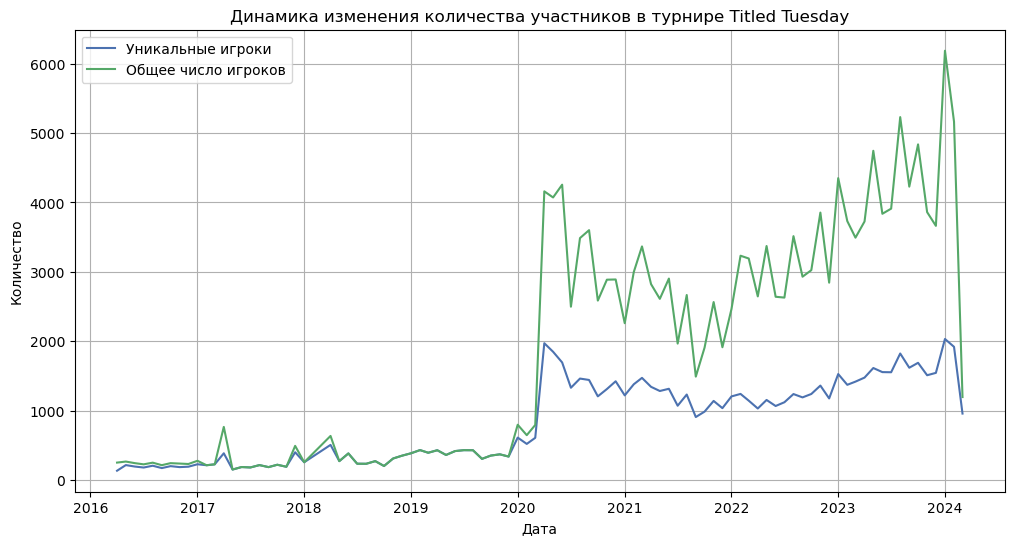

In [60]:
# визуализируем динамику прироста участников турнира
plt.style.use('seaborn-v0_8-deep')
plt.figure(figsize=(12, 6)) 
plt.plot(d["unique_players"], label="Уникальные игроки")
plt.plot(d["players_sum"], label="Общее число игроков") 
plt.title("Динамика изменения количества участников в турнире Titled Tuesday") 
plt.xlabel("Дата")
plt.ylabel("Количество") 
plt.legend()
plt.grid() 
plt.show()

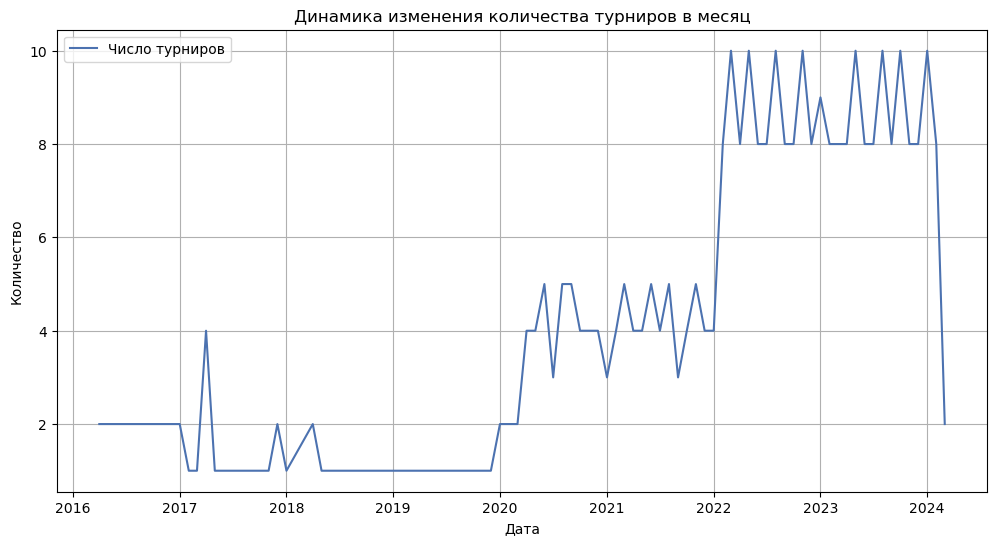

In [61]:
# динамика прироста числа турниров
plt.style.use('seaborn-v0_8-deep')
plt.figure(figsize=(12, 6)) 
plt.plot(d["unique_tmts"], label="Число турниров")
plt.xlabel("Дата")
plt.ylabel("Количество") 
plt.title("Динамика изменения количества турниров в месяц") 
plt.legend()
plt.grid() 
plt.show()

[Text(0.5, 1.0, 'Число участников по месяцам')]

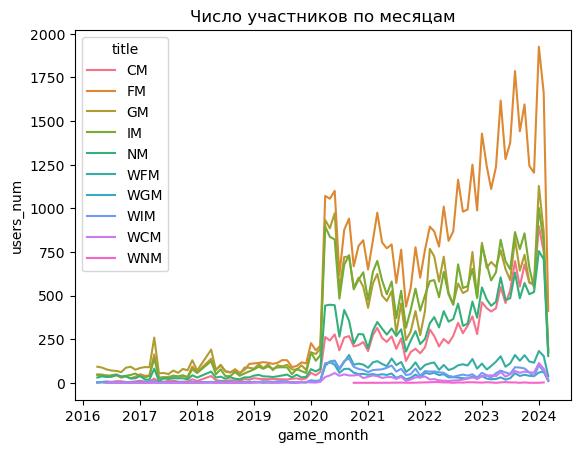

In [62]:
sns.lineplot(data=num_games_title, x='game_month', y='users_num', hue='title').set(title='Число участников по месяцам')

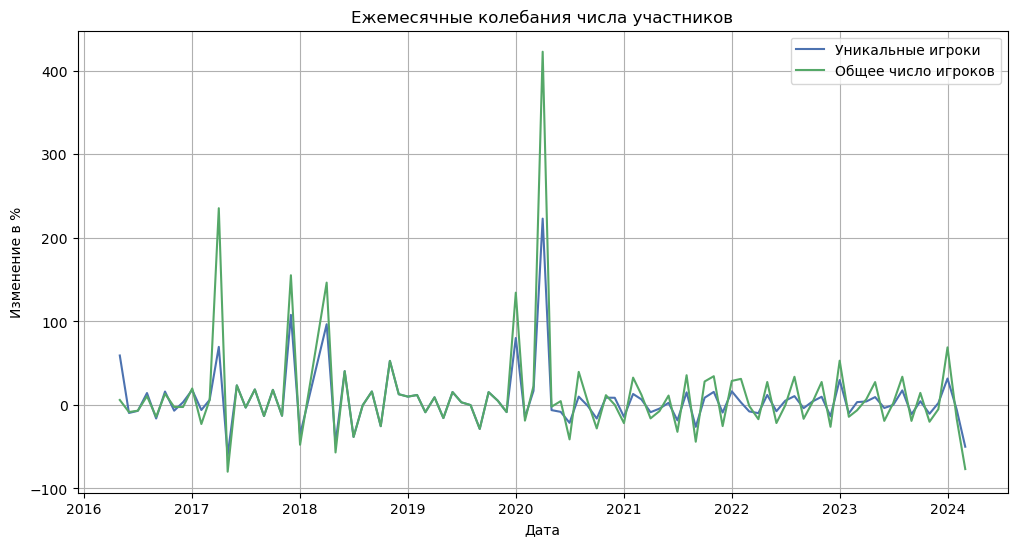

In [63]:
plt.style.use('seaborn-v0_8-deep')
plt.figure(figsize=(12, 6))
plt.plot((d["unique_players"]/d["unique_players"].shift(1) - 1)*100, label="Уникальные игроки") 
plt.plot((d["players_sum"]/d["players_sum"].shift(1) - 1)*100, label="Общее число игроков") 
plt.title("Ежемесячные колебания числа участников") 
plt.xlabel("Дата")
plt.ylabel("Изменение в %") 
plt.legend()
plt.grid()
plt.show()

### Retention rate за период август 2019 - сентябрь 2021

In [64]:
df_m_per = df.copy(deep=True)

In [65]:
# сформируем датафрейм за период 2019-08/2021-09

df_m_per = df_m_per[(df_m_per['start_time']>='2019-08-31 00:00:00') & (df_m_per['start_time']<='2021-09-01 00:00:00')]
df_m_per.head(1)

username title                      tournament_name tournament_id  \
106392  andrzej    CM  Titled-Tuesday-Blitz-August-31-2021       2546688   

                game_id          start_time         finish_time  games_count  \
106392  andrzej-2546688 2021-08-31 17:00:00 2021-08-31 19:06:32           11   

        registered_user_count  
106392                    553

In [66]:
# создаем атрибут game_month, который указывает месяц, когда игрок принимал участие в турнире
df_m_per['game_month'] = df_m_per['start_time'].dt.to_period('M')
df_m_per.head(1)

username title                      tournament_name tournament_id  \
106392  andrzej    CM  Titled-Tuesday-Blitz-August-31-2021       2546688   

                game_id          start_time         finish_time  games_count  \
106392  andrzej-2546688 2021-08-31 17:00:00 2021-08-31 19:06:32           11   

        registered_user_count game_month  
106392                    553    2021-08

In [67]:
# создаем атрибут cohort_month, который указывает на первый месяц, когда игрок принял участие в турнире серии TT
df_m_per['cohort_month'] = df_m_per.groupby('username')['game_month'].transform('min')
df_m_per.head(5)

username title                      tournament_name  \
106392              andrzej    CM  Titled-Tuesday-Blitz-August-31-2021   
106393      parintele_chess    FM  Titled-Tuesday-Blitz-August-31-2021   
106394             gmkrikor    GM  Titled-Tuesday-Blitz-August-31-2021   
106395            davigator    CM  Titled-Tuesday-Blitz-August-31-2021   
106396  rakhmanov_aleksandr    GM  Titled-Tuesday-Blitz-August-31-2021   

       tournament_id                      game_id          start_time  \
106392       2546688              andrzej-2546688 2021-08-31 17:00:00   
106393       2546688      parintele_chess-2546688 2021-08-31 17:00:00   
106394       2546688             gmkrikor-2546688 2021-08-31 17:00:00   
106395       2546688            davigator-2546688 2021-08-31 17:00:00   
106396       2546688  rakhmanov_aleksandr-2546688 2021-08-31 17:00:00   

               finish_time  games_count  registered_user_count game_month  \
106392 2021-08-31 19:06:32           11                    553    2021-08   
106393 2021-08-31 19:06:32           11                    553    2021-08   
106394 2021-08-31 19:06:32           11                    553    2021-08   
106395 2021-08-31 19:06:32           11                    553    2021-08   
106396 2021-08-31 19:06:32           11                    553    2021-08   

       cohort_month  
106392      2019-12  
106393      2020-08  
106394      2019-10  
106395      2019-11  
106396      2020-06

In [68]:
# выводим число месяцев с момента первой игры по сравнению с датой игры в конкретном турнире; формируем периоды
df_m_per['cohort_index'] = (df_m_per['game_month'] - df_m_per['cohort_month']).apply(lambda x: x.n)
df_m_per.head(2)

username title                      tournament_name  \
106392          andrzej    CM  Titled-Tuesday-Blitz-August-31-2021   
106393  parintele_chess    FM  Titled-Tuesday-Blitz-August-31-2021   

       tournament_id                  game_id          start_time  \
106392       2546688          andrzej-2546688 2021-08-31 17:00:00   
106393       2546688  parintele_chess-2546688 2021-08-31 17:00:00   

               finish_time  games_count  registered_user_count game_month  \
106392 2021-08-31 19:06:32           11                    553    2021-08   
106393 2021-08-31 19:06:32           11                    553    2021-08   

       cohort_month  cohort_index  
106392      2019-12            20  
106393      2020-08            12

In [69]:
# создаем датафрейм с агрегированными данными по первому месяцу игры и индексу; таким образом хотим проанализировать количество игроков,
# принимавших участие в турнире спустя определенное количество месяцев (индексы)
cohort_data_m_per = df_m_per.groupby(['cohort_month', 'cohort_index'])['username'].nunique().reset_index()
df_m_per.head(1);

In [70]:
# активность игроков по месяцам
cohort_count_m_per = cohort_data_m_per.pivot_table(index='cohort_month', columns='cohort_index', values='username')
cohort_count_m_per.head(5)

cohort_index     0      1      2      3      4      5      6      7      8   \
cohort_month                                                                  
2019-09       308.0  125.0  116.0  109.0  145.0  134.0  138.0  208.0  197.0   
2019-10       230.0   83.0   65.0  101.0   95.0   94.0  152.0  133.0  116.0   
2019-11       174.0   51.0   58.0   49.0   61.0  110.0   94.0   84.0   64.0   
2019-12       116.0   32.0   34.0   44.0   70.0   57.0   42.0   39.0   35.0   
2020-01       278.0   77.0   74.0  176.0  151.0  121.0  103.0   99.0   98.0   

cohort_index     9   ...     14     15     16     17     18     19     20  \
cohort_month         ...                                                    
2019-09       162.0  ...  129.0  136.0  113.0  128.0  130.0  116.0  112.0   
2019-10        99.0  ...  106.0   79.0   90.0   95.0   85.0   80.0   72.0   
2019-11        69.0  ...   64.0   73.0   62.0   55.0   46.0   51.0   50.0   
2019-12        39.0  ...   51.0   43.0   34.0   32.0   30.0   25.0   27.0   
2020-01        86.0  ...   80.0   64.0   64.0   70.0   57.0   60.0    NaN   

cohort_index     21    22     23  
cohort_month                      
2019-09       112.0  96.0  110.0  
2019-10        63.0  77.0    NaN  
2019-11        49.0   NaN    NaN  
2019-12         NaN   NaN    NaN  
2020-01         NaN   NaN    NaN  

[5 rows x 24 columns]

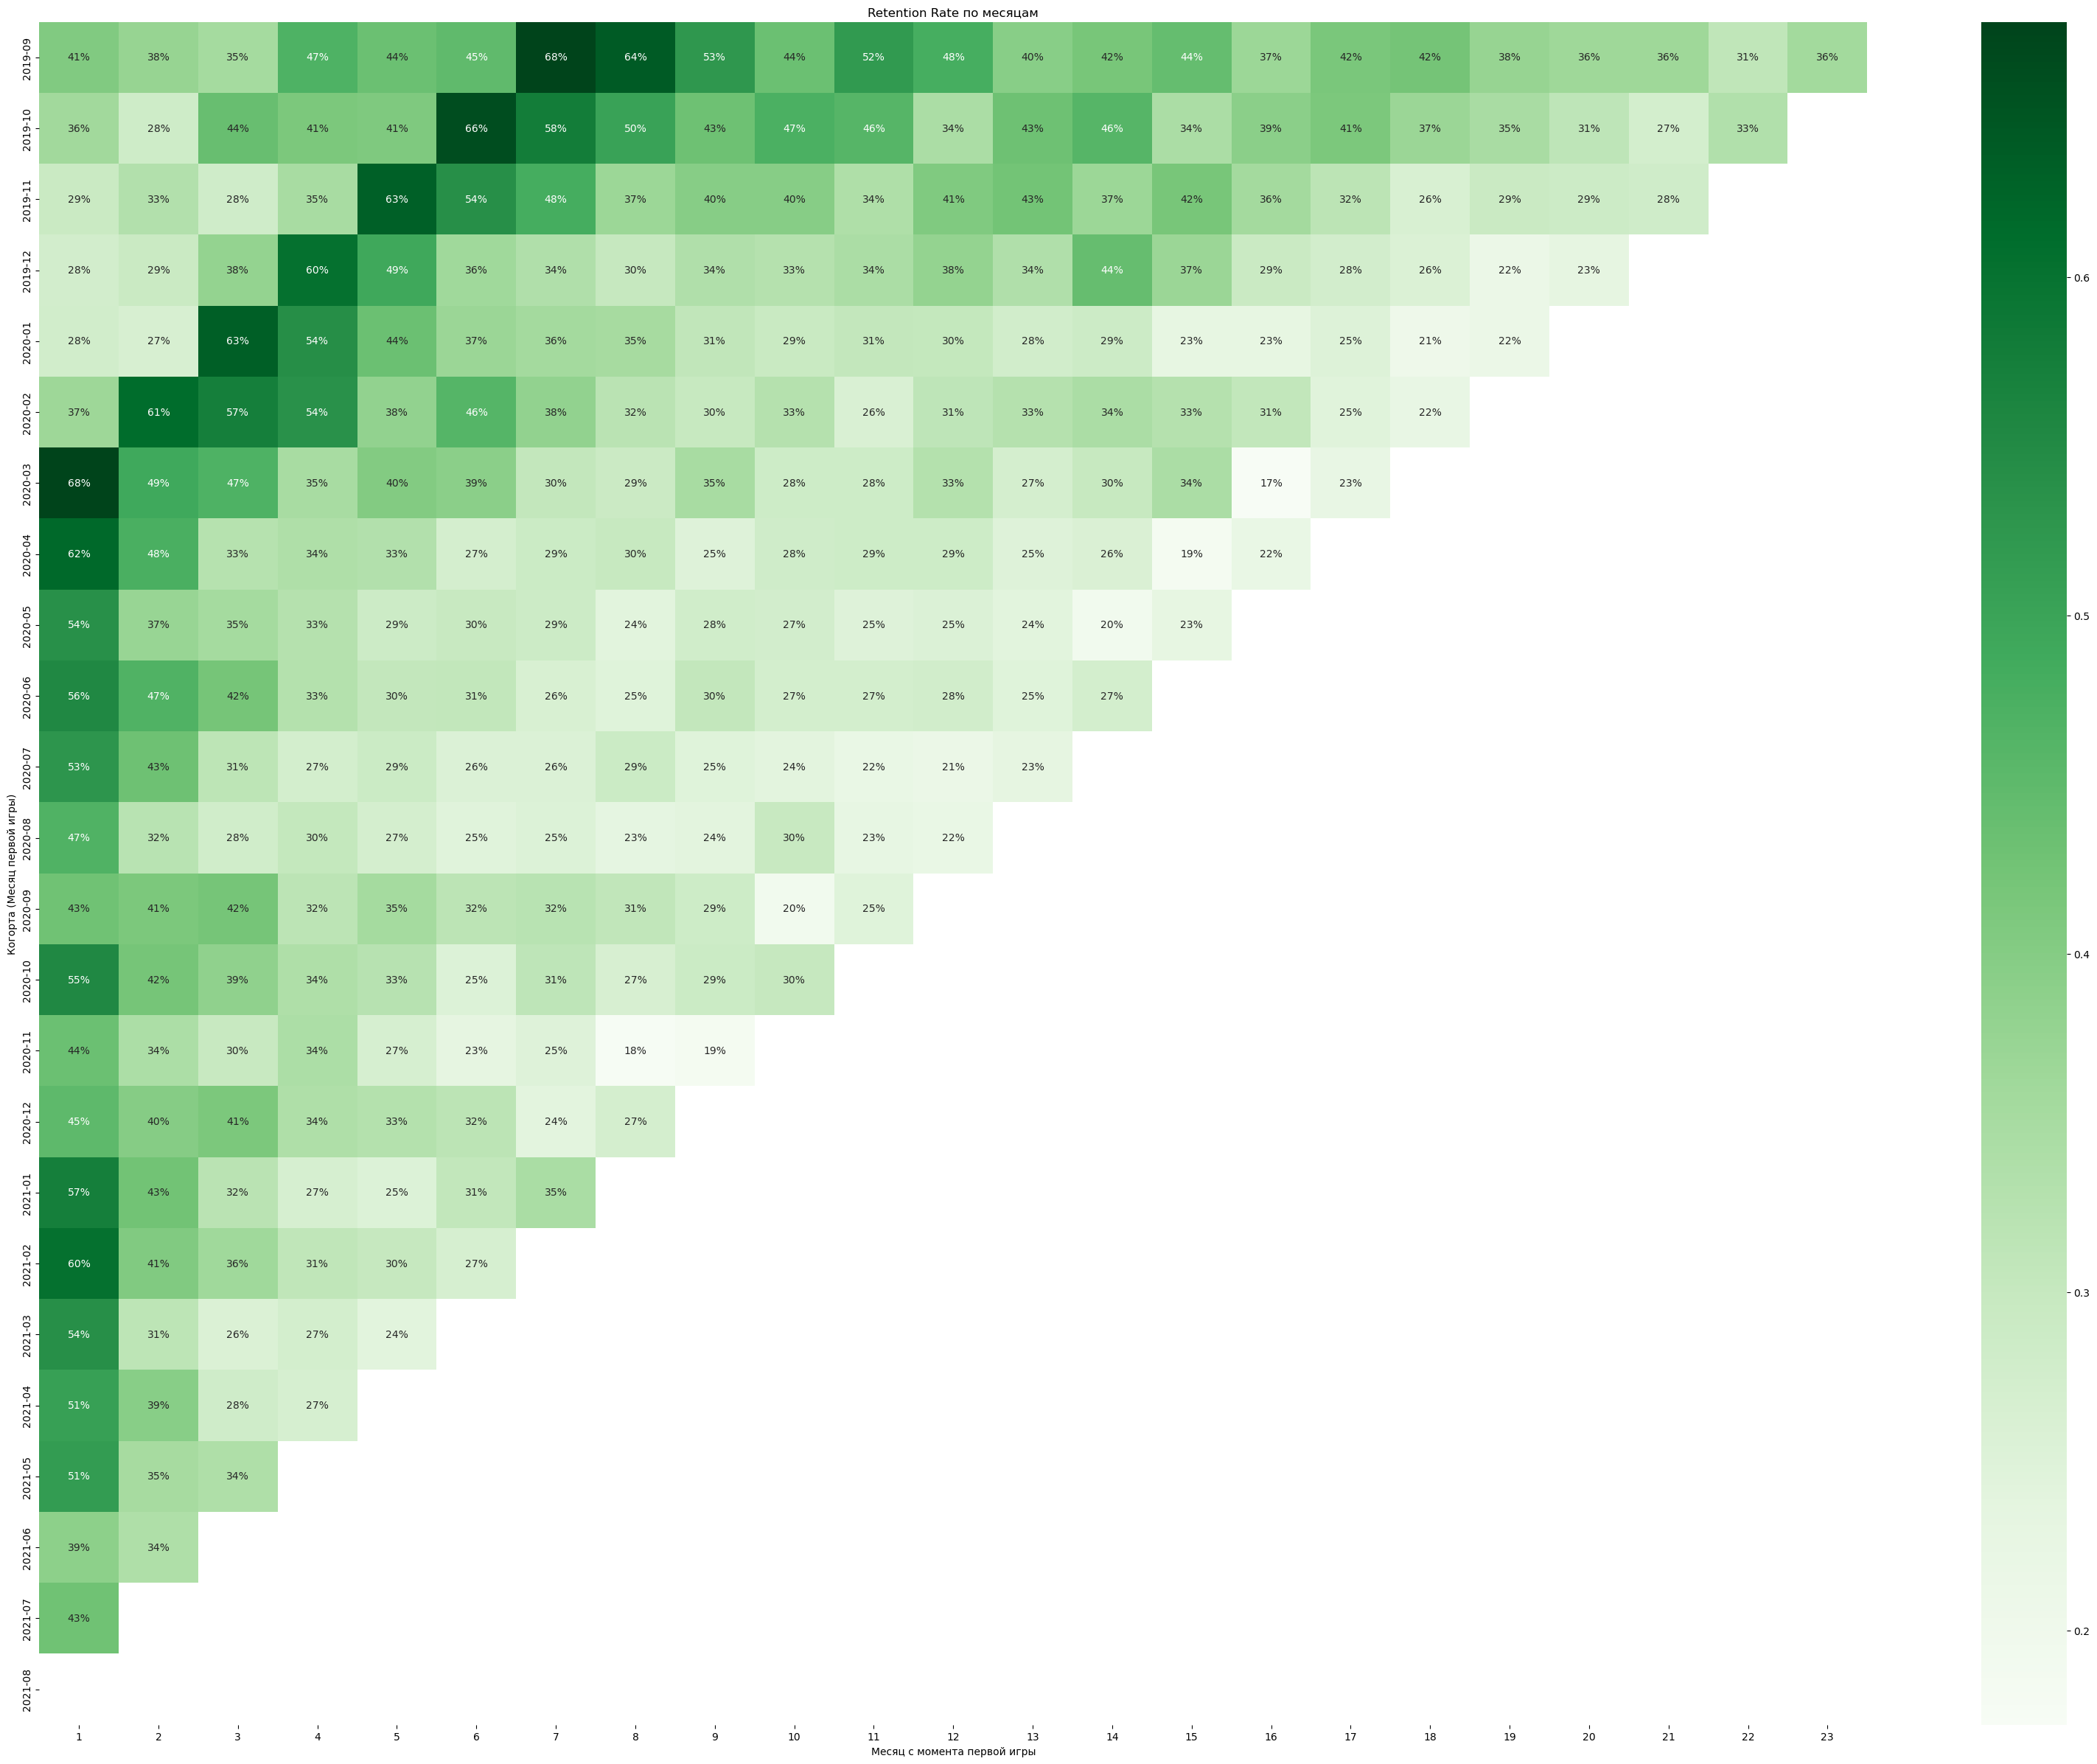

In [71]:
# Вычисление размера когорты
cohort_sizes_m_per = cohort_count_m_per.iloc[:,0]

# Вычисление Retention Rate
retention_m_per = cohort_count_m_per.divide(cohort_sizes_m_per, axis=0)

# Удаление первого столбца, так как он представляет размер когорты, а не Retention Rate
retention_m_per = retention_m_per.drop(columns=0)

# Визуализация Retention Rate с помощью тепловой карты
plt.figure(figsize=(40, 30))
sns.heatmap(retention_m_per, annot=True, fmt='.0%', cmap='Greens')
plt.title('Retention Rate по месяцам')
plt.ylabel('Когорта (Месяц первой игры)')
plt.xlabel('Месяц с момента первой игры')
plt.show()

## **Выводы**

1. 
На начальном этапе жизненного цикла турнира наибольшую стабильность принятия участия в турнире показывали игроки, которые присоединились к нему в самом начале - январь 2016. В течение 2 лет активность постепенно снизилась. В остальных категориях игроки сохраняли наибольшую активность в первые недели после первой игры, далее их активность снижалась.

2. 
В феврале и марте 2018 года отмечаем полностью белые ячейки графика. Причина: в эти месяцы турнир не проводился. https://www.chess.com/tournament/live/titled-tuesdays?&page=14. 

3. 
**Вторую жизнь турнир получил в начале 2020 года, когда по всему миру начался карантин связанный с эпидемией COVID-19. Шахматисты стали больше времени проводить дома. Для поддержания игровой практики игроки вернулись к форматам онлайн-турниров.**

**Начиная с отметки 2020 года каждый месяц отмечается явный тренд на существенный прирост Retention rate, который сохраняется даже после снятия ограничений карантина и по текущий день.** 

4. 
**Начиная с 2021 года впервые присоединившиеся игроки сохраняют очень стабильную активность.**

Сериалы и фильмы о шахматах по типу "Ход королевы" (2020), рекламные акции в виде коллабораций со зведными личностями(фотосессия Криштиану Роналду и Лионеля Месси на чемодане в виде шахматной доски) или иные PR-акции, а также шахматные читерские скандалы, заявления знаменитых шахматистов главным образом способствуют привлечению массового сегмента любителей шахмат. 

Причина:
 Титулованные же игроки принимают решение об участии на другой почве: спортивная и коммерческая. Призовой фонд турнира год от года увеличивается(https://www.chess.com/news/view/titled-cup-titled-tuesdays-just-got-even-more-fierce). А сами шахматисты завели и продолжают активно заводить аккаунты на стриминговых сервисах, где транслируют свои игры в прямом эфире при этом зарабатывая не только на спонсорах, но и на донатах зрителей. В связи с этим популярность турнира сохраняется и растет. Об этом свидетельствуют ячейки на графике в области 2021-2024 гг., которые имеют более насыщенный зеленый оттенок цвета. Более подробно посмотрим на них ниже по кварталам.

5. 
Отмечаем прирост новых игроков во второй половине января 2024. Это может быть связано с новостным аноносом chess.com повышении призовых и большом призовом фонде за участие в турнирах Titled Tuesday 2023-2024:  https://www.chess.com/news/view/titled-cup-titled-tuesdays-just-got-even-more-fierce

**Задача на перспективу.**
Было бы здорово оценить прирост числа стримеров со временем и провести корреляцию с данным графиком, но публичное API Chess.com не содержит информации о времени, когда пользователь стал стримером, а только инфо о статусе(стример или нет). Для подобного рода задач требуется накапливать данные, либо получить доступ к логам через Dev API.

#### Анализ retention rate по неделям:

Давайте проанализируем активность по неделям за период 2022-08-01 - 2023-02-28.

In [72]:
# создаем deep copy датафрейма df для анализа по неделям
df_w = df.copy(deep=True)

In [73]:
# сформируем датафрейм за период 2022-03/2023-02

df_w = df_w[(df_w['start_time']<='2023-02-28 00:00:00') & (df_w['start_time']>='2022-08-01 00:00:00')]
df_w.head(1)

username title                             tournament_name  \
55017  andrzej    CM  Late-Titled-Tuesday-Blitz-February-21-2023   

      tournament_id          game_id          start_time         finish_time  \
55017       3833636  andrzej-3833636 2023-02-21 22:00:00 2023-02-22 00:07:10   

       games_count  registered_user_count  
55017           11                    391

In [74]:
# создаем атрибут game_week, который указывает неделю, когда игрок принимал участие в турнире
df_w['game_week'] = df_w['start_time'].dt.to_period('W')
df_w.head(1)

username title                             tournament_name  \
55017  andrzej    CM  Late-Titled-Tuesday-Blitz-February-21-2023   

      tournament_id          game_id          start_time         finish_time  \
55017       3833636  andrzej-3833636 2023-02-21 22:00:00 2023-02-22 00:07:10   

       games_count  registered_user_count              game_week  
55017           11                    391  2023-02-20/2023-02-26

In [75]:
# создаем атрибут cohort_month, который указывает на первую неделю, когда игрок принял участие в турнире серии TT
df_w['cohort_week'] = df_w.groupby('username')['game_week'].transform('min')

In [76]:
# выводим число недель с момента первой игры по сравнению с датой игры в конкретном турнире; формируем периоды
df_w['cohort_index'] = (df_w['game_week'] - df_w['cohort_week']).apply(lambda x: x.n)

In [77]:
# создаем датафрейм с агрегированными данными по первой неделе игры и индексу; таким образом хотим проанализировать количество игроков,
# принимавших участие в турнире спустя определенное количество недель (индексы)
cohort_data_w = df_w.groupby(['cohort_week', 'cohort_index'])['username'].nunique().reset_index()

In [78]:
# активность игроков по неделям
cohort_count_w = cohort_data_w.pivot_table(index='cohort_week', columns='cohort_index', values='username')

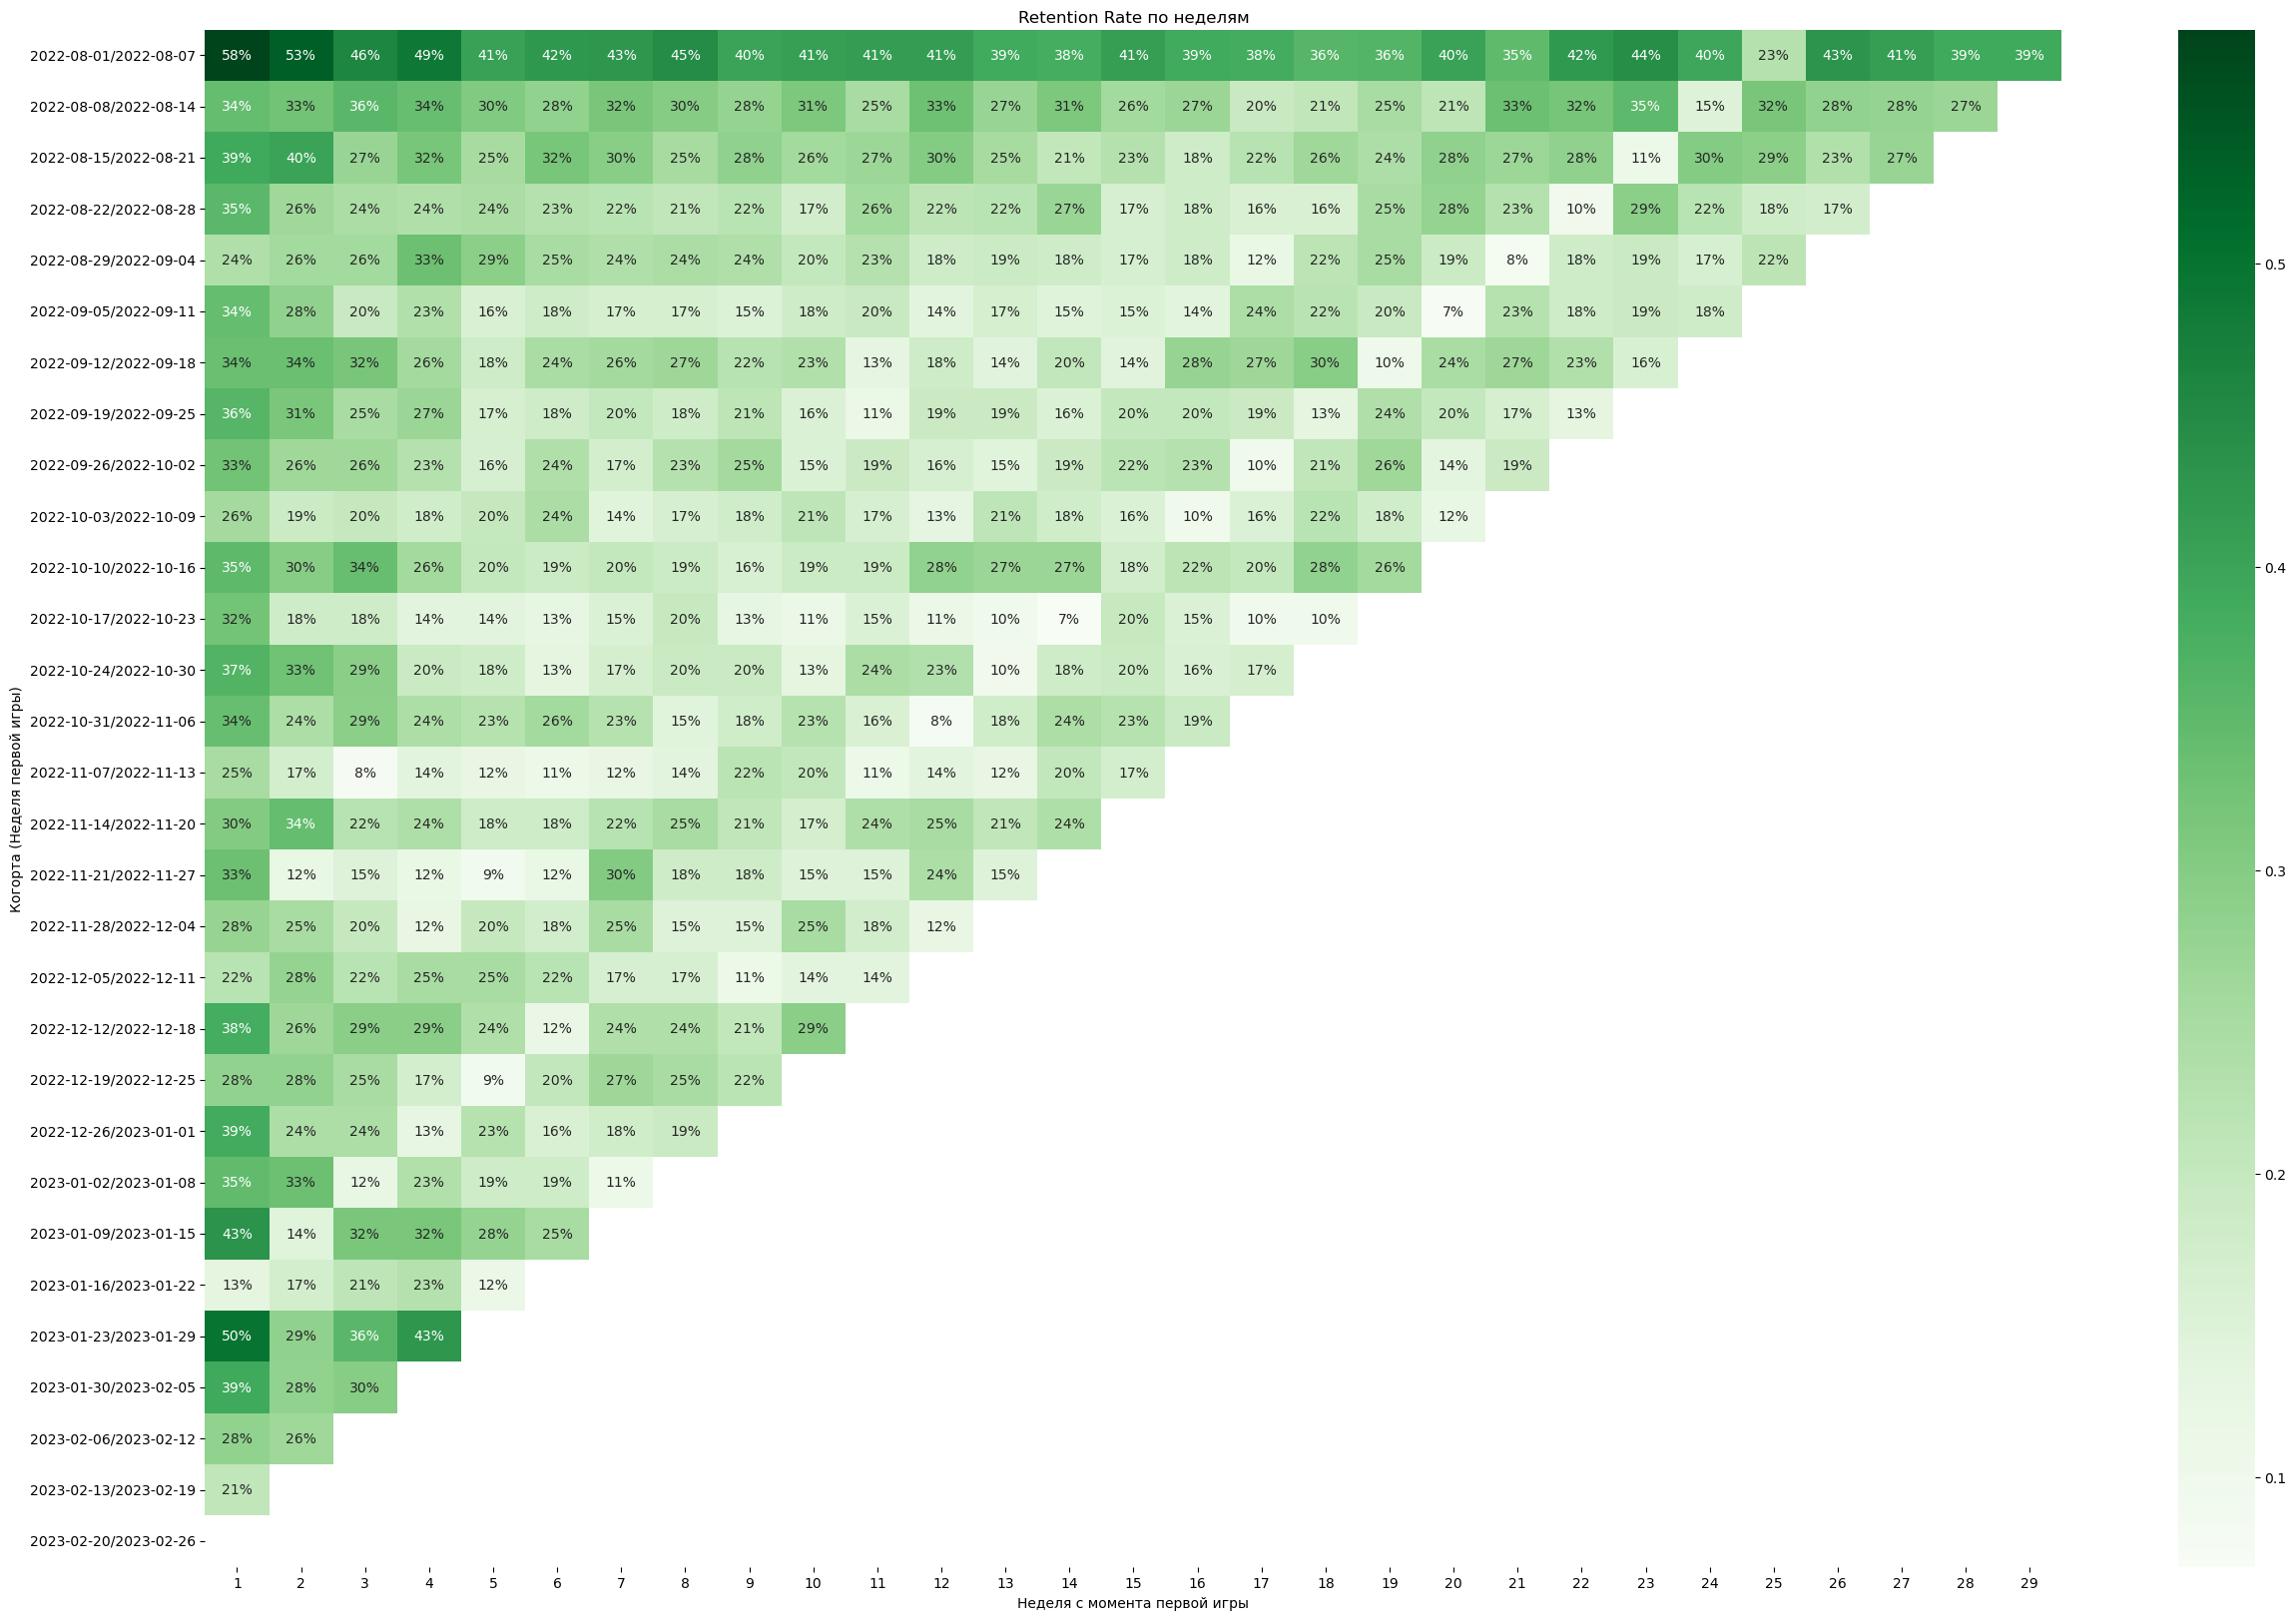

In [79]:
# Вычисление размера когорты
cohort_sizes_w = cohort_count_w.iloc[:,0]

# Вычисление Retention Rate
retention_w = cohort_count_w.divide(cohort_sizes_w, axis=0)

# Удаление первого столбца, так как он представляет размер когорты, а не Retention Rate
retention_w = retention_w.drop(columns=0)

# Визуализация Retention Rate с помощью тепловой карты
plt.figure(figsize=(30, 20))
sns.heatmap(retention_w, annot=True, fmt='.0%', cmap='Greens')
plt.title('Retention Rate по неделям')
plt.ylabel('Когорта (Неделя первой игры)')
plt.xlabel('Неделя с момента первой игры')
plt.show()

Цветовая палитра ячеек, относящихся к индексу первого участия в турнире "2023-01-16/2023-01-22", более светлая. 
**Вероятные причины:**
1. Турнир Tata Steel Chess Masters проходивший с 13 по 29 января 2023 года с участием ключевых гроссмейстеров. https://www.chess.com/ru/events/2023-tata-steel-chess-masters.
2. Другие локальные турниры, проходящие онлайн. 

**Истинная причина:**  на неделе с 23 по 29 января 2023 chess.com провел только один турнир Titled Tuesday вместо традиционных двух: https://www.chess.com/news/view/nakamura-wins-titled-tuesday-january-24-2023. Он состоялся 25 января в 01:00. Давайте проверим это по нашему датафрейму.



In [80]:
df_w[(df_w['start_time']<='2023-02-01 00:00:00') & (df_w['start_time']>='2023-01-01 00:00:00')]\
    .groupby(['tournament_name'])['game_week'].nunique()


tournament_name
Early-Titled-Tuesday-Blitz-January-03-2023    1
Early-Titled-Tuesday-Blitz-January-10-2023    1
Early-Titled-Tuesday-Blitz-January-17-2023    1
Early-Titled-Tuesday-Blitz-January-31-2023    1
Late-Titled-Tuesday-Blitz-January-03-2023     1
Late-Titled-Tuesday-Blitz-January-10-2023     1
Late-Titled-Tuesday-Blitz-January-17-2023     1
Late-Titled-Tuesday-Blitz-January-24-2023     1
Late-Titled-Tuesday-Blitz-January-31-2023     1
Name: game_week, dtype: int64

Что самое интересное - отмена турнира была вызвана возросшей нагрузкой на сервера в этот период. По данным Chess.com трафик на платформе с января по февраль почти удвоился! Новость: https://www.chess.com/blog/CHESScom/chess-is-booming-and-our-servers-are-struggling.

#### Анализ retention rate по кварталам:

In [81]:
# создаем deep copy датафрейма df для анализа по кварталам
df_q = df.copy(deep=True)

In [82]:
# создаем атрибут game_quarter, который указывает квартал, когда игрок принимал участие в турнире
df_q['game_quarter'] = df_q['start_time'].dt.to_period('Q')

In [83]:
# создаем атрибут cohort_month, который указывает на первый квартал, когда игрок принял участие в турнире серии TT
df_q['cohort_quarter'] = df_q.groupby('username')['game_quarter'].transform('min')

In [84]:
# выводим число кварталов с момента первой игры по сравнению с датой игры в конкретном турнире; формируем периоды
df_q['cohort_index'] = (df_q['game_quarter'] - df_q['cohort_quarter']).apply(lambda x: x.n)

In [85]:
# создаем датафрейм с агрегированными данными по первому кварталу игры и индексу; таким образом хотим проанализировать количество игроков,
# принимавших участие в турнире спустя определенное количество кварталов (индексы)
cohort_data_q = df_q.groupby(['cohort_quarter', 'cohort_index'])['username'].nunique().reset_index()

In [86]:
# активность игроков по кварталам
cohort_count_q = cohort_data_q.pivot_table(index='cohort_quarter', columns='cohort_index', values='username')

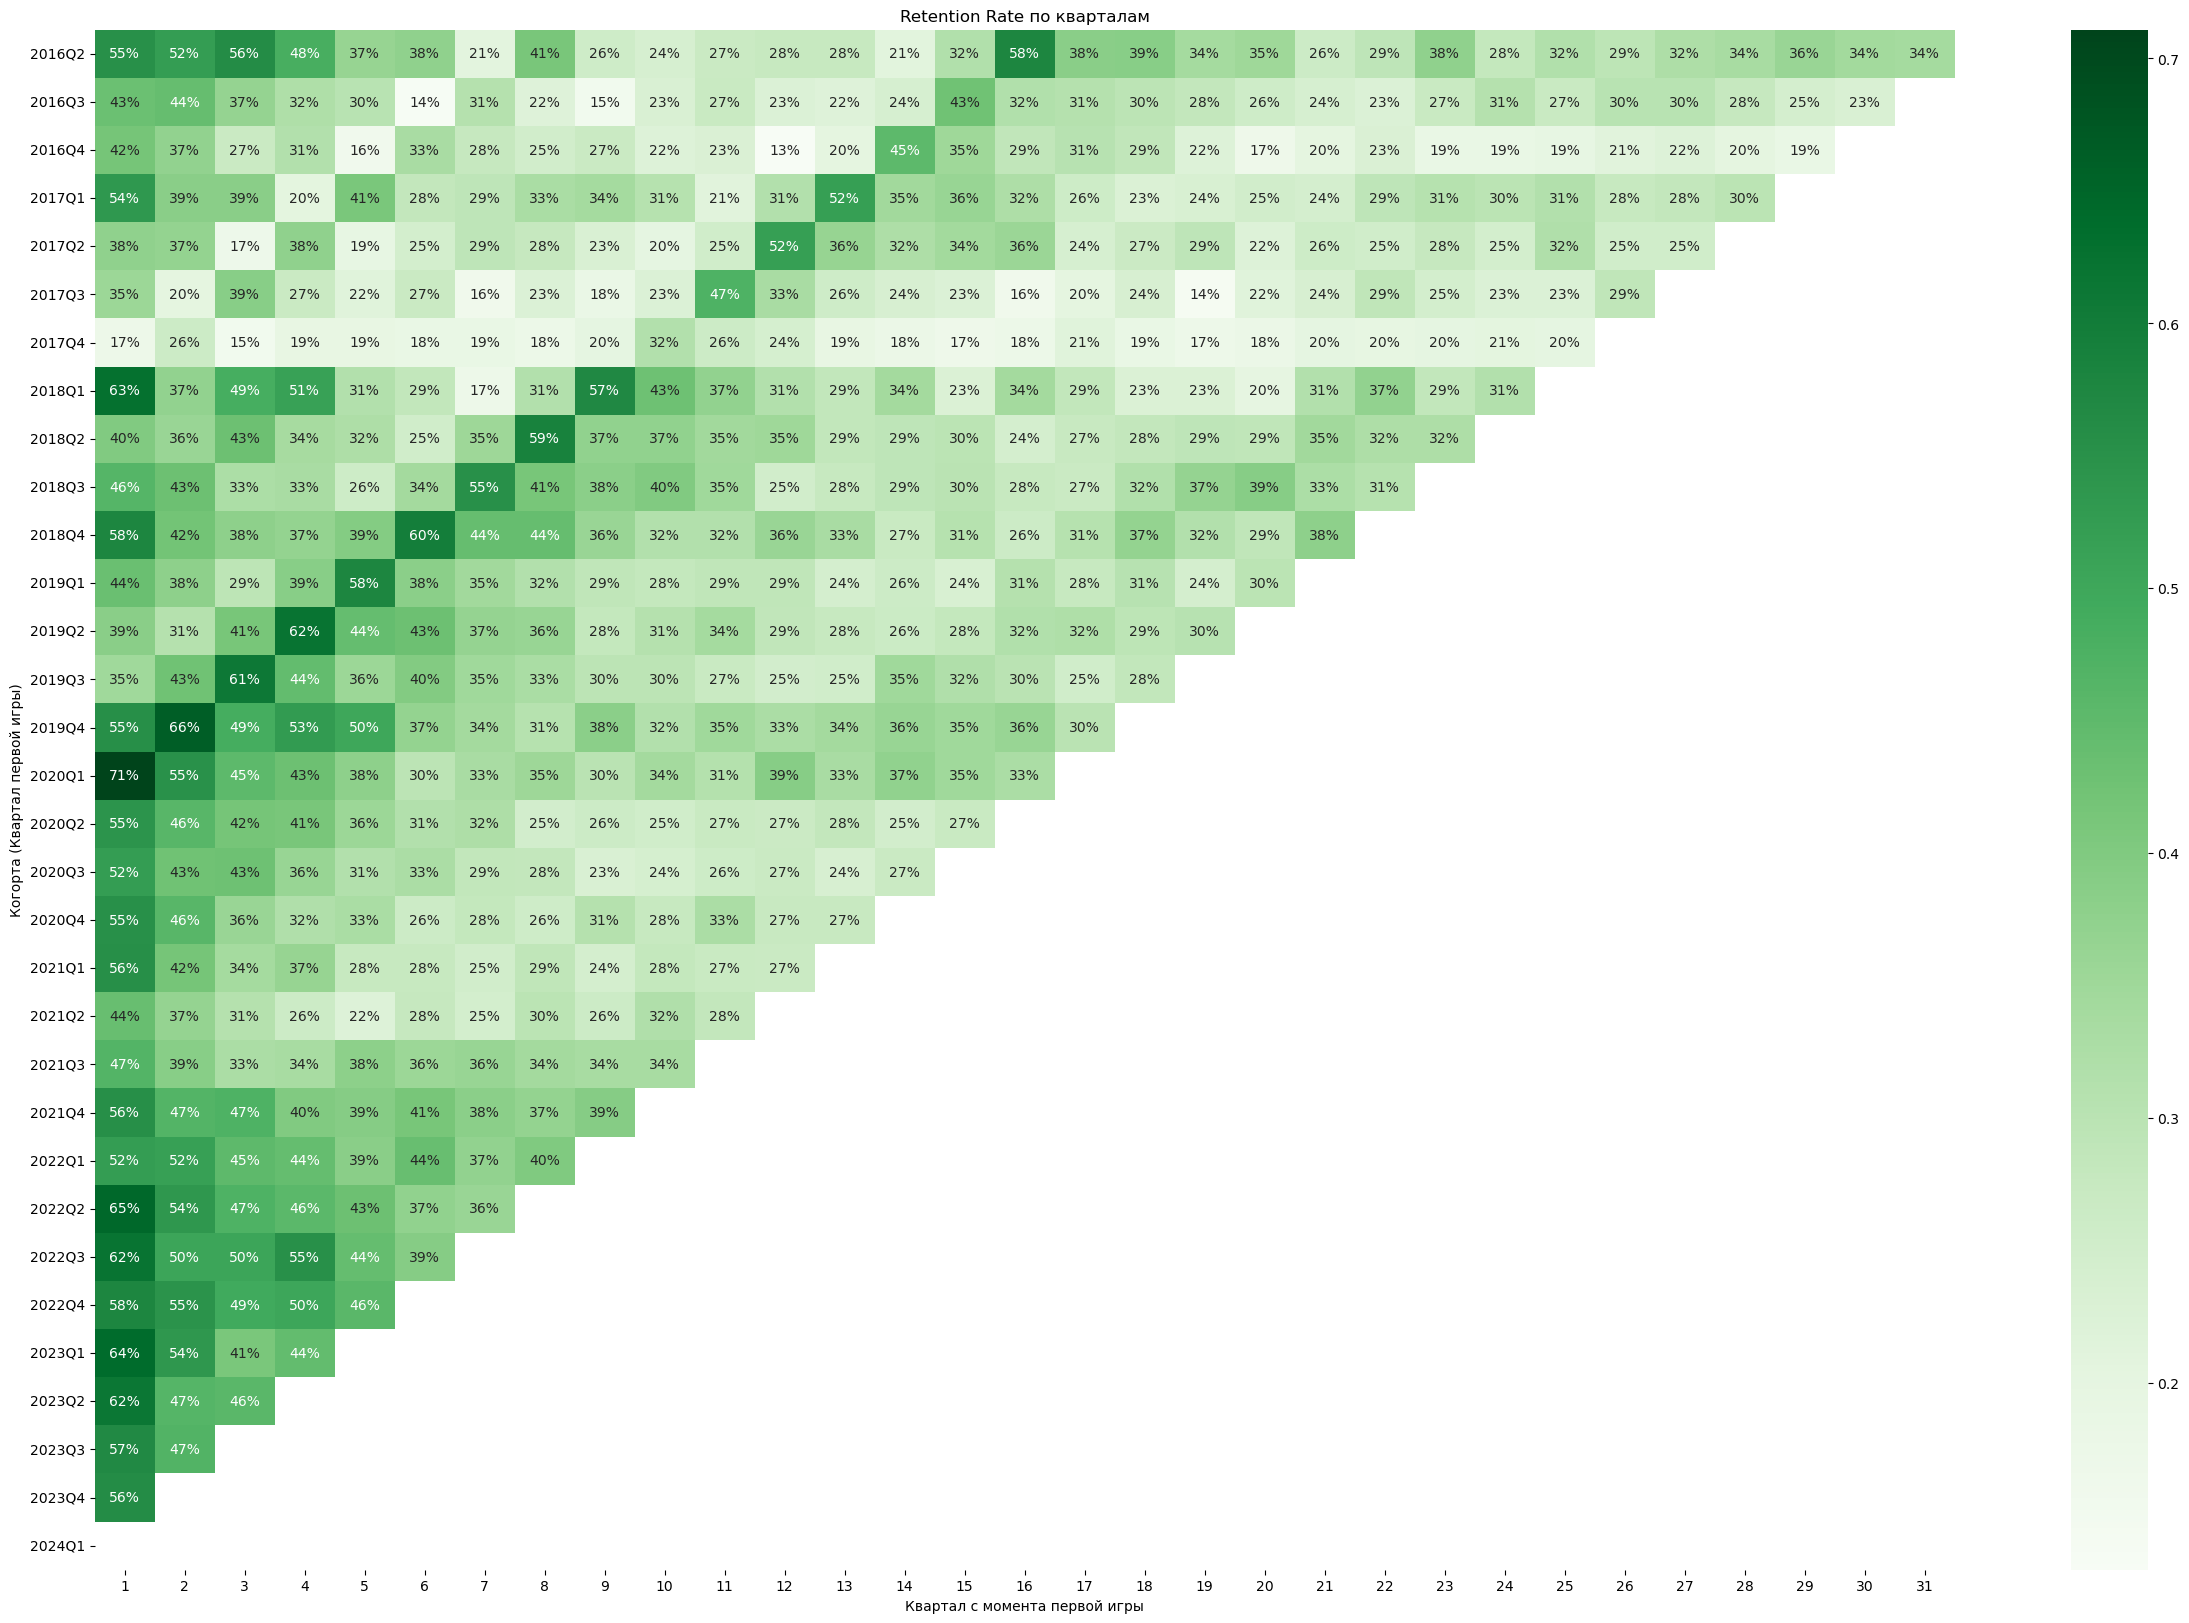

In [87]:
# Вычисление размера когорты
cohort_sizes_q = cohort_count_q.iloc[:,0]

# Вычисление Retention Rate
retention_q = cohort_count_q.divide(cohort_sizes_q, axis=0)

# Удаление первого столбца, так как он представляет размер когорты, а не Retention Rate
retention_q = retention_q.drop(columns=0)

# Визуализация Retention Rate с помощью тепловой карты
plt.figure(figsize=(30, 20))
sns.heatmap(retention_q, annot=True, fmt='.0%', cmap='Greens')
plt.title('Retention Rate по кварталам')
plt.ylabel('Когорта (Квартал первой игры)')
plt.xlabel('Квартал с момента первой игры')
plt.show()

Дополнительно отметим повышение Retention rate в 1 кваратале 2022 года: в это время формат Titled Tuesday изменился - вместо одного турнира за один день стало проводиться два турнира - Early and Late.

Зафиксируем более отчетливо прирост активности в период и после периода ковидных ограничений.

Число игр (вклад в игровую активность) - это, можно сказать, аналог выручки. Давайте построим метрику LTV по кварталам.
Убедимся в этом на квартальном графике.

#### Расчет LTV

In [88]:
# Расчет LTV для каждой когорты; games_count - аналог profit;
cohort_revenue = df_q.groupby(['cohort_quarter', 'cohort_index']).agg({'games_count': 'sum'}).reset_index()
cohort_revenue

cohort_quarter  cohort_index  games_count
0           2016Q2             0         6921
1           2016Q2             1         3978
2           2016Q2             2         3708
3           2016Q2             3         3437
4           2016Q2             4         4580
..             ...           ...          ...
523         2023Q3             1         9031
524         2023Q3             2         6523
525         2023Q4             0         9724
526         2023Q4             1         8019
527         2024Q1             0         9592

[528 rows x 3 columns]

In [89]:
# Подсчет общего числа матчей в когорту на каждого уникального игрока
cohort_ltv = cohort_revenue.merge(cohort_sizes_q.to_frame(name='cohort_size'), on='cohort_quarter')
cohort_ltv['LTV'] = cohort_ltv['games_count'] / cohort_ltv['cohort_size']
cohort_ltv

cohort_quarter  cohort_index  games_count  cohort_size        LTV
0           2016Q2             0         6921        367.0  18.858311
1           2016Q2             1         3978        367.0  10.839237
2           2016Q2             2         3708        367.0  10.103542
3           2016Q2             3         3437        367.0   9.365123
4           2016Q2             4         4580        367.0  12.479564
..             ...           ...          ...          ...        ...
523         2023Q3             1         9031        283.0  31.911661
524         2023Q3             2         6523        283.0  23.049470
525         2023Q4             0         9724        251.0  38.741036
526         2023Q4             1         8019        251.0  31.948207
527         2024Q1             0         9592        268.0  35.791045

[528 rows x 5 columns]

In [90]:
# сводная таблица LTV
ltv_pivot = cohort_ltv.pivot_table(index='cohort_quarter', columns='cohort_index', values='LTV')
ltv_pivot

cohort_index           0          1          2          3          4   \
cohort_quarter                                                          
2016Q2          18.858311  10.839237  10.103542   9.365123  12.479564   
2016Q3          14.922581   7.838710   6.825806   8.774194   4.516129   
2016Q4          14.416667   7.166667   8.148148   3.611111   5.648148   
2017Q1          13.496063  12.283465   6.062992   5.984252   2.047244   
2017Q2          17.792208   6.233766   6.298701   1.688312   6.948052   
2017Q3          11.612903   5.806452   2.043011   6.451613   4.086022   
2017Q4          12.368421   1.710526   5.219298   2.324561   3.377193   
2018Q1          10.000000  12.857143   6.285714   7.142857   8.285714   
2018Q2          15.601375   5.704467   5.773196   6.838488   5.601375   
2018Q3          12.113821   7.642276   6.585366   4.959350   4.227642   
2018Q4          13.245614   9.561404   6.403509   5.614035   5.438596   
2019Q1          13.200000   7.244444   5.822222   4.311111   6.840000   
2019Q2          13.045977   6.321839   4.482759   8.068966  31.103448   
2019Q3          12.426036   5.443787   7.775148  29.946746  18.698225   
2019Q4          12.739726  12.636986  35.027397  26.301370  25.047945   
2020Q1          15.903614  38.389558  26.546185  19.461847  19.040161   
2020Q2          36.794140  26.260601  21.272938  20.320740  18.955281   
2020Q3          30.644258  24.955182  20.274510  20.490196  14.481793   
2020Q4          27.413669  28.172662  23.305755  13.176259  11.633094   
2021Q1          29.451613  26.928315  16.283154  15.336918  18.017921   
2021Q2          29.087629  17.690722  14.118557  14.402062  14.855670   
2021Q3          24.026316  20.407895  19.539474  23.230263  23.157895   
2021Q4          27.541353  33.413534  27.127820  26.962406  23.571429   
2022Q1          33.502538  27.974619  24.121827  23.228426  24.121827   
2022Q2          39.613924  41.911392  29.449367  29.588608  31.189873   
2022Q3          37.905405  41.869369  35.279279  29.283784  32.207207   
2022Q4          34.331839  43.605381  35.614350  31.914798  27.623318   
2023Q1          39.841463  43.016260  33.491870  24.727642  23.922764   
2023Q2          39.515385  37.865385  28.811538  25.638462        NaN   
2023Q3          40.734982  31.911661  23.049470        NaN        NaN   
2023Q4          38.741036  31.948207        NaN        NaN        NaN   
2024Q1          35.791045        NaN        NaN        NaN        NaN   

cohort_index           5          6          7          8          9   ...  \
cohort_quarter                                                         ...   
2016Q2           5.476839   7.275204   2.070845   7.629428   3.732970  ...   
2016Q3           4.838710   1.354839   5.290323   3.161290   2.451613  ...   
2016Q4           1.574074   5.555556   3.796296   3.240741   3.796296  ...   
2017Q1           7.244094   4.251969   4.488189   5.511811   4.960630  ...   
2017Q2           2.662338   3.636364   3.896104   4.675325   3.116883  ...   
2017Q3           2.903226   4.086022   3.225806   3.655914   2.903226  ...   
2017Q4           3.070175   3.157895   2.894737   2.719298   3.986842  ...   
2018Q1           5.714286   6.000000   3.714286   8.228571  32.657143  ...   
2018Q2           4.639175   4.123711   6.958763  27.570447  18.659794  ...   
2018Q3           4.065041   6.219512  24.317073  16.422764  15.658537  ...   
2018Q4           7.105263  28.236842  20.614035  20.684211  18.429825  ...   
2019Q1          24.715556  16.444444  13.724444  13.640000  10.511111  ...   
2019Q2          18.908046  18.908046  16.689655  15.425287  11.379310  ...   
2019Q3          16.272189  15.100592  13.928994  11.260355  10.349112  ...   
2019Q4          25.993151  19.513699  14.315068  15.520548  22.376712  ...   
2020Q1          17.096386  13.959839  12.767068  17.759036  19.923695  ...   
2020Q2          14.019275  13.764842  16.360062  13.052429  13.315343  ...   
2020Q3          13.495798  15.65266

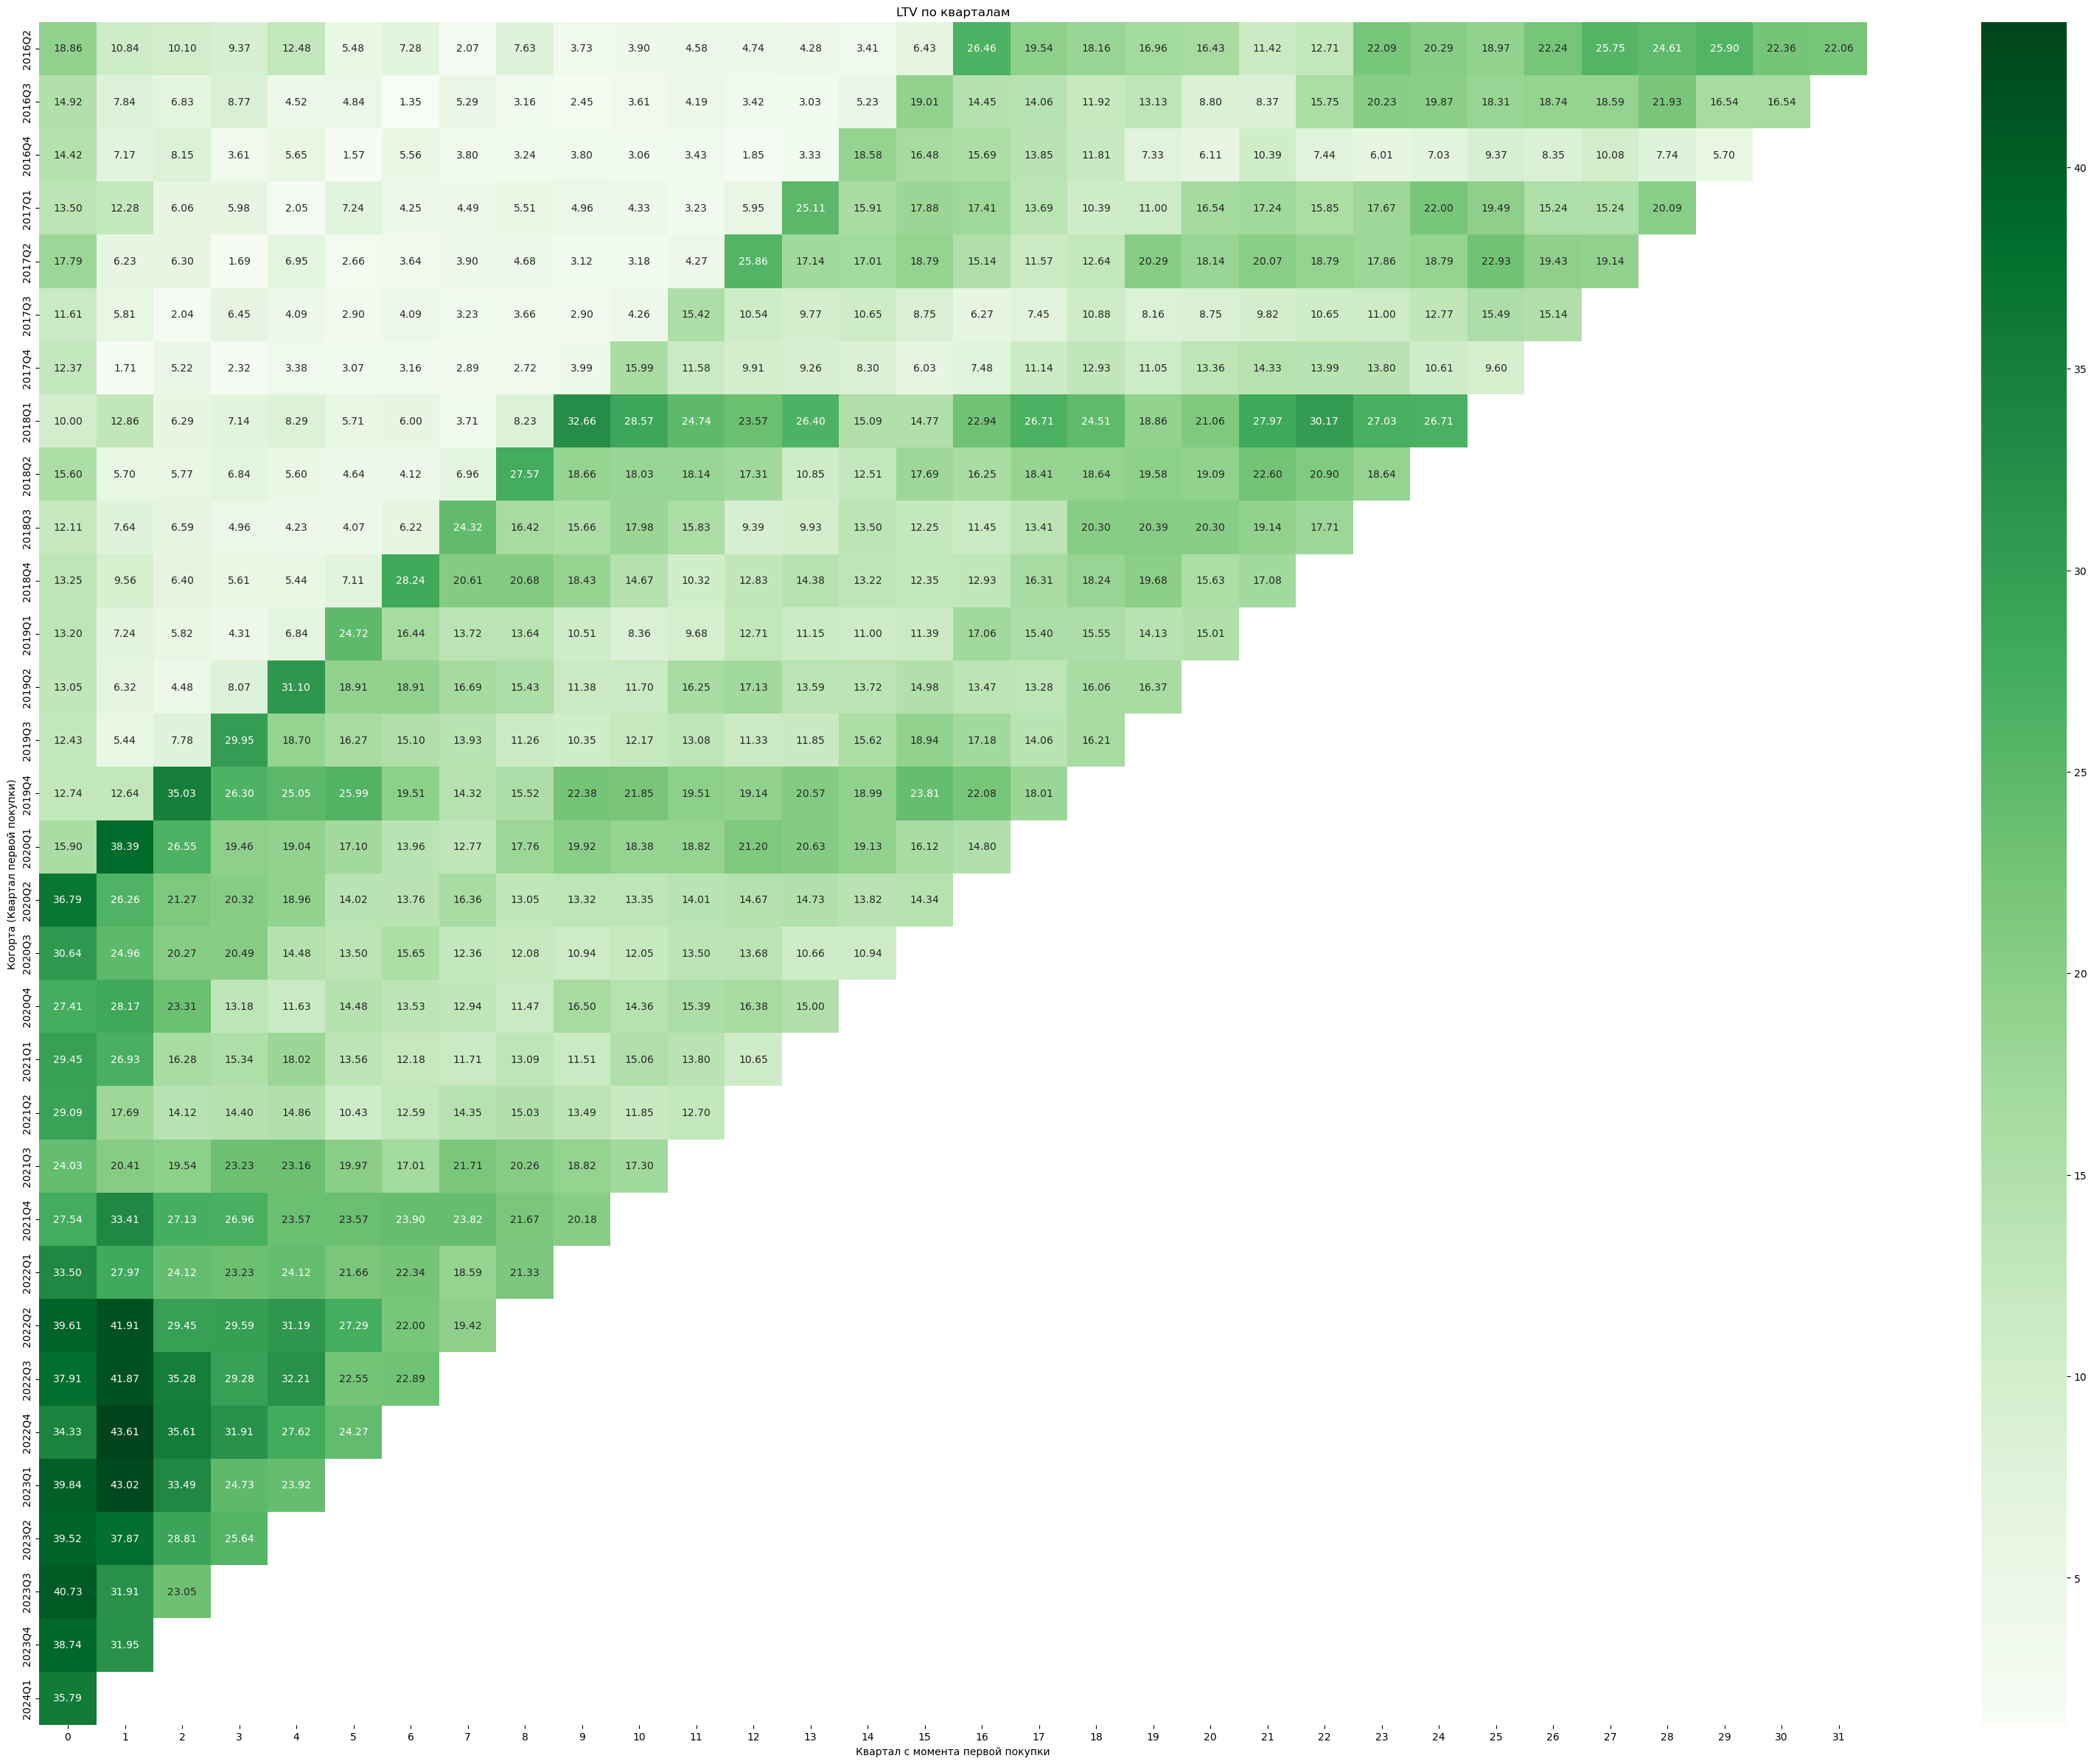

In [91]:
# строим heatmap
plt.figure(figsize=(40, 30))
sns.heatmap(ltv_pivot, annot=True, fmt='.2f', cmap='Greens')
plt.title('LTV по кварталам')
plt.ylabel('Когорта (Квартал первой покупки)')
plt.xlabel('Квартал с момента первой покупки')
plt.show()

Наибольший рост активности отмечается в период после 2020 года. Пиковые значения активности приходятся на период с 2022 года. 
Это коррелирует с выводами по Retention rate.

## Общий вывод по когортному анализу: 

**Ковидные ограничения в 2020, цифровизация общества и маркетинговые кампании платформы Chess.com в 2021-2023 гг. привели к восстановлению популярности турнира Titled Tuesday.**

## RFM анализ

Целью анализа является определение интенсивности участия различных категорий (титулованные игроки) шахматистов в турнирах Titled Tuesday. Таким образом оценим некую величину вклада в развитие сообщества.

In [93]:
# импорт дополнительной таблички для обогащения данными

df_profiles = pd.read_csv('ALL/df_all_profiles.csv')
df_profiles.head(5)

Unnamed: 0                                             avatar  player_id  \
0           0  https://images.chesscomfiles.com/uploads/v1/us...   18800602   
1           1  https://images.chesscomfiles.com/uploads/v1/us...   29499974   
2           2  https://images.chesscomfiles.com/uploads/v1/us...   30610578   
3           3  https://images.chesscomfiles.com/uploads/v1/us...   13013662   
4           4  https://images.chesscomfiles.com/uploads/v1/us...   69412324   

                                                 @id  \
0             https://api.chess.com/pub/player/123lt   
1          https://api.chess.com/pub/player/124chess   
2          https://api.chess.com/pub/player/1977ivan   
3         https://api.chess.com/pub/player/1stsecond   
4  https://api.chess.com/pub/player/4thd-alpeacef...   

                                                url             name  \
0                https://www.chess.com/member/123lt      Tingjie Lei   
1             https://www.chess.com/member/124chess    Дмитрий Хегай   
2             https://www.chess.com/member/1977Ivan  Ivan Ivanisevic   
3            https://www.chess.com/member/1stSecond  Nikita Meshkovs   
4  https://www.chess.com/member/4thD-alpeacefulmoon    Robert Markus   

              username title  followers                               country  \
0                123lt    GM        139  https://api.chess.com/pub/country/CN   
1             124chess    GM         77  https://api.chess.com/pub/country/RU   
2             1977ivan    GM        193  https://api.chess.com/pub/country/RS   
3            1stsecond    GM        565  https://api.chess.com/pub/country/LV   
4  4thd-alpeacefulmoon    GM          8  https://api.chess.com/pub/country/RS   

   last_online      joined   status  is_streamer  verified   league  \
0   1703685878  1410059361  premium        False     False    Stone   
1   1709089367  1471316272  premium        False     False   Bronze   
2   1709071186  1477565847  premium        False     False  Crystal   
3   1709066169  1375617889  premium        False     False    Elite   
4   1706379687  1576488055  premium        False     False    Stone   

     location twitch_url                                  players.stats.url  
0         NaN        NaN             https://api.chess.com/pub/player/123lt  
1  Красноярск        NaN          https://api.chess.com/pub/player/124chess  
2    Belgrade        NaN          https://api.chess.com/pub/player/1977ivan  
3        Riga        NaN         https://api.chess.com/pub/player/1stsecond  
4         NaN        NaN  https://api.chess.com/pub/player/4thd-alpeacef...

In [94]:
df_profiles.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12072 entries, 0 to 12071
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         12072 non-null  int64 
 1   avatar             8019 non-null   object
 2   player_id          12072 non-null  int64 
 3   @id                12072 non-null  object
 4   url                12072 non-null  object
 5   name               9556 non-null   object
 6   username           12072 non-null  object
 7   title              12072 non-null  object
 8   followers          12072 non-null  int64 
 9   country            12072 non-null  object
 10  last_online        12072 non-null  int64 
 11  joined             12072 non-null  int64 
 12  status             12072 non-null  object
 13  is_streamer        12072 non-null  bool  
 14  verified           12072 non-null  bool  
 15  league             10096 non-null  object
 16  location           5461 non-null   objec

In [95]:
# добавим только колонки, необходимые для анализа
# добавим доп. столбец 
df_rfm = pd.merge(df_q, df_profiles[['username','is_streamer','followers', 'status', 'country']], how = 'left', on='username')
df_rfm['country'] = df_rfm['country'].str.split('/').str[-1]
df_rfm

username title                          tournament_name  \
0                andrzej    CM  Late-Titled-Tuesday-Blitz-March-05-2024   
1                    gmg    GM  Late-Titled-Tuesday-Blitz-March-05-2024   
2          ukchessbomber    FM  Late-Titled-Tuesday-Blitz-March-05-2024   
3       danielnaroditsky    GM  Late-Titled-Tuesday-Blitz-March-05-2024   
4        musiccitymaster    FM  Late-Titled-Tuesday-Blitz-March-05-2024   
...                  ...   ...                                      ...   
174057             pomoc   WGM             *** Titled Tuesday 3|2 Blitz   
174058      underdogchss    GM             *** Titled Tuesday 3|2 Blitz   
174059        angry_serb    IM             *** Titled Tuesday 3|2 Blitz   
174060           usurpov    FM             *** Titled Tuesday 3|2 Blitz   
174061   alex_stripunsky    GM             *** Titled Tuesday 3|2 Blitz   

       tournament_id                   game_id          start_time  \
0            4605130           andrzej-4605130 2024-03-05 22:00:00   
1            4605130               gmg-4605130 2024-03-05 22:00:00   
2            4605130     ukchessbomber-4605130 2024-03-05 22:00:00   
3            4605130  danielnaroditsky-4605130 2024-03-05 22:00:00   
4            4605130   musiccitymaster-4605130 2024-03-05 22:00:00   
...              ...                       ...                 ...   
174057        646318              pomoc-646318 2016-04-05 18:00:00   
174058        646318       underdogchss-646318 2016-04-05 18:00:00   
174059        646318         angry_serb-646318 2016-04-05 18:00:00   
174060        646318            usurpov-646318 2016-04-05 18:00:00   
174061        646318    alex_stripunsky-646318 2016-04-05 18:00:00   

               finish_time  games_count  registered_user_count game_quarter  \
0      2024-03-06 00:06:07           11                    502       2024Q1   
1      2024-03-06 00:06:07           11                    502       2024Q1   
2      2024-03-06 00:06:07           11                    502       2024Q1   
3      2024-03-06 00:06:07           11                    502       2024Q1   
4      2024-03-06 00:06:07           11                    502       2024Q1   
...                    ...          ...                    ...          ...   
174057 2016-04-05 18:13:36            9                    123       2016Q2   
174058 2016-04-05 18:13:36            9                    123       2016Q2   
174059 2016-04-05 18:13:36            9                    123       2016Q2   
174060 2016-04-05 18:13:36            9                    123       2016Q2   
174061 2016-04-05 18:13:36            9                    123       2016Q2   

       cohort_quarter  cohort_index is_streamer  followers   status country  
0              2018Q3            22       False      135.0  premium      PL  
1              2016Q2            31       False     2751.0  premium      US  
2              2020Q4            13       False      117.0  premium      XE  
3              2016Q2            31        True    28748.0  premium      US  
4              2019Q3            18       False      445.0  premium      US  
...               ...           ...         ...        ...      ...     ...  
174057         2016Q2             0       False       87.0  premium      HU  
174058         2016Q2             0       False       55.0  premium      ZA  
174059         2016Q2             0       False      143.0  premium      RS  
174060         2016Q2             0       False      306.0  premium      AR  
174061         2016Q2             0       False       57.0  premium      US  

[174062 rows x 16 columns]

In [96]:
# число шахматистов разных категорий

test_value = df_rfm.groupby(['title'])['username'].nunique()
test_value.sort_values(ascending=False)

title
FM     2141
IM     1279
NM     1016
GM      918
CM      886
WFM     302
WIM     177
WGM     129
WCM     127
WNM       5
Name: username, dtype: int64

In [97]:
# атрибут total_input - аналог total_sales, является в величиной активности игроков и будет использоваться в качестве Monetary Value
df_rfm['total_input'] = df_rfm['games_count']

In [98]:
snapshot_date = df_rfm['start_time'].max() + timedelta(days=1)
print(snapshot_date)

2024-03-06 22:00:00


In [99]:
# game_id - уникальный номер участия в турнире
data_process = df_rfm.groupby(['username']).agg({
        'start_time': lambda x: (snapshot_date - x.max()).days,
        'game_id': 'count',
        'total_input': 'sum'})

data_process.rename(columns={'start_time': 'Recency',
                         'game_id': 'Frequency',
                         'total_input': 'MonetaryValue'}, inplace=True)

In [100]:
data_process.head(5)

Recency  Frequency  MonetaryValue
username                                       
017290           1828          2             20
01roman            43          8             88
03revilo          127         28            308
0815original      260          1             11
0gzpanda          162         14            154

In [101]:
print(data_process.head())
print('В датафрейме {} строк и {} столбцов.'
      .format(data_process.shape[0], data_process.shape[1]))

              Recency  Frequency  MonetaryValue
username                                       
017290           1828          2             20
01roman            43          8             88
03revilo          127         28            308
0815original      260          1             11
0gzpanda          162         14            154
В датафрейме 7556 строк и 3 столбцов.


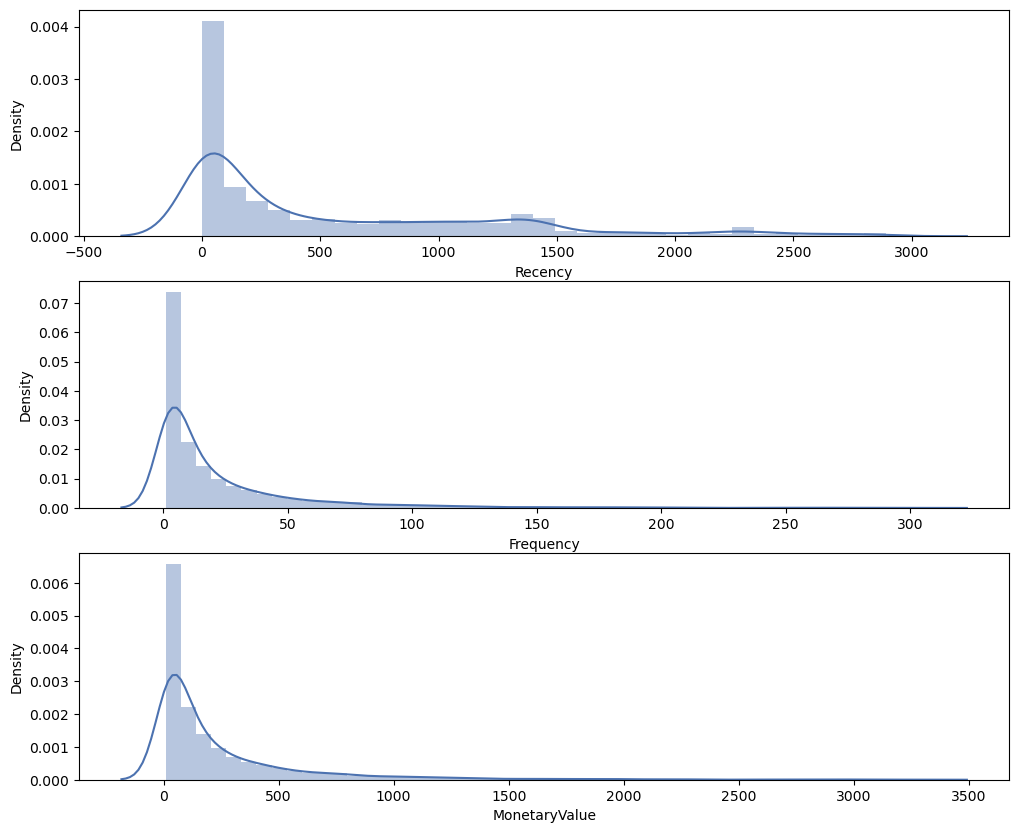

In [102]:
plt.figure(figsize=(12,10))

plt.subplot(3, 1, 1); sns.distplot(data_process['Recency'])

plt.subplot(3, 1, 2); sns.distplot(data_process['Frequency'])

plt.subplot(3, 1, 3); sns.distplot(data_process['MonetaryValue'])

plt.show()

In [103]:
data_process['Recency_log'] = np.where(data_process['Recency'] == 0, 0,np.log(data_process['Recency']))

data_process['Frequency_log'] = np.where(data_process['Frequency'] == 0, 0,np.log(data_process['Frequency']))

data_process['Monetary_log'] = np.where(data_process['MonetaryValue'] == 0, 0,np.log(data_process['MonetaryValue']))

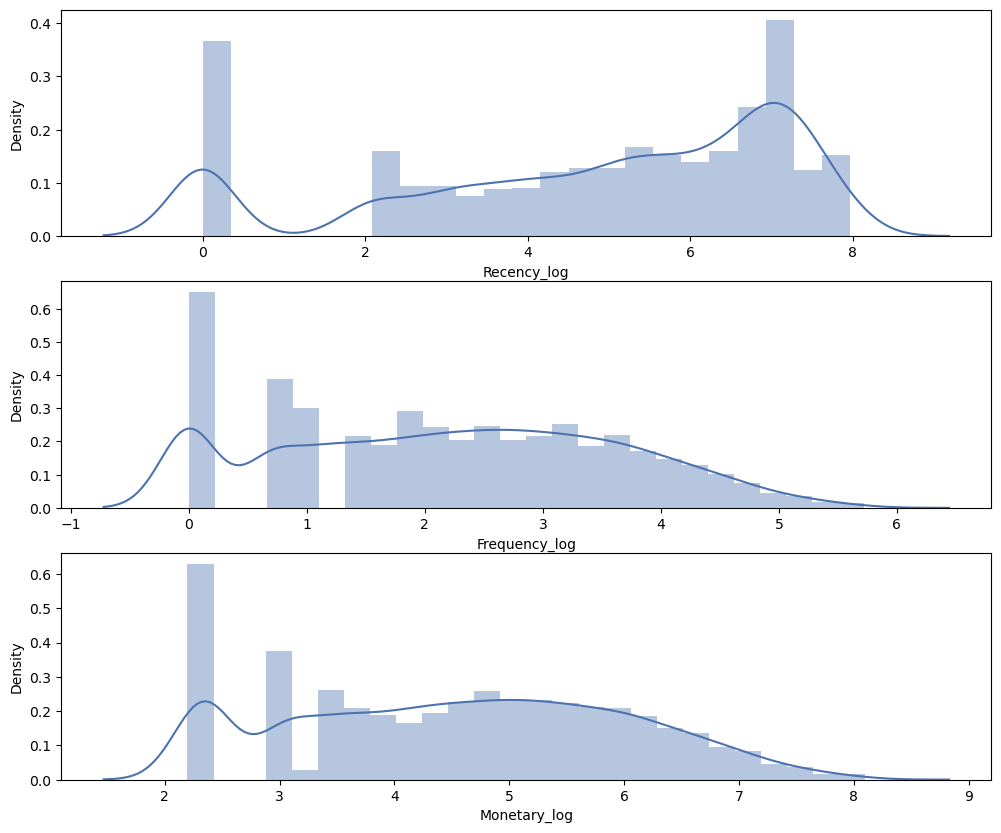

In [104]:
plt.figure(figsize=(12,10))

plt.subplot(3, 1, 1); sns.distplot(data_process['Recency_log'])

plt.subplot(3, 1, 2); sns.distplot(data_process['Frequency_log'])

plt.subplot(3, 1, 3); sns.distplot(data_process['Monetary_log'])

plt.show()

Распределение RFM парамтеров неравномерное

In [105]:
# --Calculate R and F groups--
# Create labels for Recency and Frequency
r_labels = range(5, 0, -1); f_labels = range(1, 6)
# Assign these labels to 4 equal percentile groups 
r_groups = pd.cut(data_process['Recency_log'], bins=5, labels=r_labels)
# Assign these labels to 4 equal percentile groups 
f_groups = pd.cut(data_process['Frequency_log'], bins=5, labels=f_labels)
# Create new columns R and F 
data_process = data_process.assign(R = r_groups.values, F = f_groups.values)
data_process.head()

Recency  Frequency  MonetaryValue  Recency_log  Frequency_log  \
username                                                                      
017290           1828          2             20     7.510978       0.693147   
01roman            43          8             88     3.761200       2.079442   
03revilo          127         28            308     4.844187       3.332205   
0815original      260          1             11     5.560682       0.000000   
0gzpanda          162         14            154     5.087596       2.639057   

              Monetary_log  R  F  
username                          
017290            2.995732  1  1  
01roman           4.477337  3  2  
03revilo          5.730100  2  3  
0815original      2.397895  2  1  
0gzpanda          5.036953  2  3

In [106]:
# Create labels for MonetaryValue
m_labels = range(1, 6)
# Assign these labels to three equal percentile groups 
m_groups = pd.cut(data_process['Monetary_log'], bins=5, labels=m_labels)
# Create new column M
data_process = data_process.assign(M = m_groups.values)

In [107]:
data_process.tail(10)

Recency  Frequency  MonetaryValue  Recency_log  \
username                                                          
zuratqebuchava         1         35            385     0.000000   
zurzan                15        101           1090     2.708050   
zuzanak             1310          1             10     7.177782   
zverevlev            505         36            378     6.224558   
zverr1                 1         91           1000     0.000000   
zvonokchess1996     2864          2             18     7.959975   
zwischenzugged      1373          4             37     7.224753   
zzoom                918          1             11     6.822197   
zzww18              1674          1             10     7.422971   
zzzombie            2282          1             10     7.732808   

                 Frequency_log  Monetary_log  R  F  M  
username                                               
zuratqebuchava        3.555348      5.953243  5  4  4  
zurzan                4.615121      6.993933  4  5  5  
zuzanak               0.000000      2.302585  1  1  1  
zverevlev             3.583519      5.934894  2  4  4  
zverr1                4.510860      6.907755  5  4  4  
zvonokchess1996       0.693147      2.890372  1  1  1  
zwischenzugged        1.386294      3.610918  1  2  2  
zzoom                 0.000000      2.397895  1  1  1  
zzww18                0.000000      2.302585  1  1  1  
zzzombie              0.000000      2.302585  1  1  1

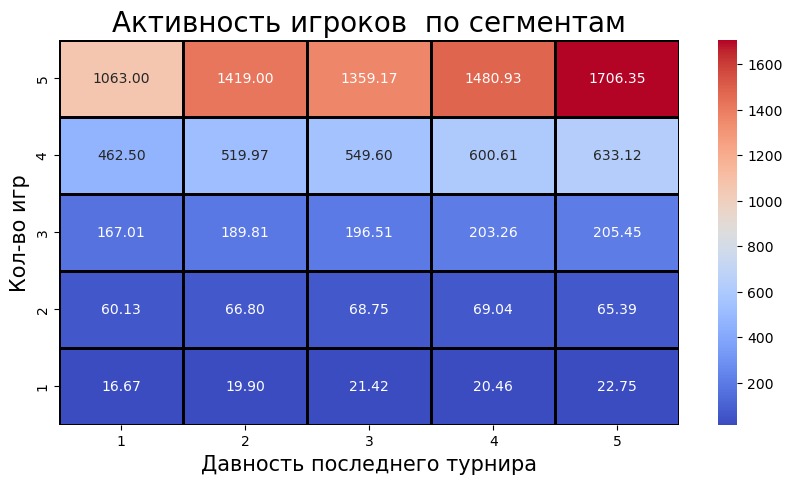

In [108]:
rfm_table = data_process.pivot_table(
                        index='F', 
                        columns='R', 
                        values='MonetaryValue', 
                        aggfunc=np.mean).applymap(float)

plt.figure(figsize=(10, 5))
sns.heatmap(rfm_table, annot=True, fmt='.2f', linewidths=1, linecolor='black', 
            cmap = 'coolwarm')
plt.title('Активность игроков  по сегментам',fontsize=20, color='black')
plt.xlabel('Давность последнего турнира',fontsize=15, color='black')
plt.ylabel('Кол-во игр',fontsize=15, color='black')
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.show()

In [109]:
segm_map={
    r'[1-2][1-2]' : 'в зоне бездействия',
    r'[1-2][3-4]' : 'в зоне риска',
    r'[1-2]5' : 'не можем потерять',
    r'3[1-2]' : 'засыпающий',
    r'33' : 'нуждающийся во внимании',
    r'[3-4][4-5]' : 'постоянный игрок',
    r'41' : 'перспективный игрок',
    r'51' : 'последний игрок',
    r'[4-5][2-3]' : 'потенциальный лоялист',
    r'5[4-5]' : 'чемпион'
}
data_process['Segment'] = data_process['R'].astype(str)+data_process['F'].astype(str)
data_process['Segment'] = data_process['Segment'].replace(segm_map,regex=True)

In [110]:
data_process

Recency  Frequency  MonetaryValue  Recency_log  \
username                                                          
017290              1828          2             20     7.510978   
01roman               43          8             88     3.761200   
03revilo             127         28            308     4.844187   
0815original         260          1             11     5.560682   
0gzpanda             162         14            154     5.087596   
...                  ...        ...            ...          ...   
zvonokchess1996     2864          2             18     7.959975   
zwischenzugged      1373          4             37     7.224753   
zzoom                918          1             11     6.822197   
zzww18              1674          1             10     7.422971   
zzzombie            2282          1             10     7.732808   

                 Frequency_log  Monetary_log  R  F  M             Segment  
username                                                                   
017290                0.693147      2.995732  1  1  1  в зоне бездействия  
01roman               2.079442      4.477337  3  2  2          засыпающий  
03revilo              3.332205      5.730100  2  3  3        в зоне риска  
0815original          0.000000      2.397895  2  1  1  в зоне бездействия  
0gzpanda              2.639057      5.036953  2  3  3        в зоне риска  
...                        ...           ... .. .. ..                 ...  
zvonokchess1996       0.693147      2.890372  1  1  1  в зоне бездействия  
zwischenzugged        1.386294      3.610918  1  2  2  в зоне бездействия  
zzoom                 0.000000      2.397895  1  1  1  в зоне бездействия  
zzww18                0.000000      2.302585  1  1  1  в зоне бездействия  
zzzombie              0.000000      2.302585  1  1  1  в зоне бездействия  

[7556 rows x 10 columns]

In [111]:
# топ-20 самых играющих шахматистов
data_process[(data_process['Segment'].str.contains('чемпион'))].sort_values(by='MonetaryValue', ascending=False).head(20)

Recency  Frequency  MonetaryValue  Recency_log  \
username                                                               
djano                       1        305           3299          0.0   
fairchess_on_youtube        1        299           3209          0.0   
tigrvshlyape                1        290           3147          0.0   
jospem                      1        290           3136          0.0   
mikhail_golubev             1        289           3116          0.0   
oleksandr_bortnyk           1        279           3021          0.0   
bazar-wokzal                1        277           3014          0.0   
wpwpwp-2015                 1        278           3012          0.0   
asahoffmann                 1        276           3003          0.0   
guillembaches               1        276           2988          0.0   
zhigalko_sergei             1        270           2960          0.0   
biostatistician             1        270           2913          0.0   
msb2                        1        269           2896          0.0   
hikaru                      1        269           2892          0.0   
alexrustemov                1        262           2864          0.0   
goltsevdmitry2000           1        262           2861          0.0   
mishanick                   1        262           2833          0.0   
ural58                      1        260           2832          0.0   
mikesailer                  1        259           2799          0.0   
dosto07                     1        252           2749          0.0   

                      Frequency_log  Monetary_log  R  F  M  Segment  
username                                                             
djano                      5.720312      8.101375  5  5  5  чемпион  
fairchess_on_youtube       5.700444      8.073715  5  5  5  чемпион  
tigrvshlyape               5.669881      8.054205  5  5  5  чемпион  
jospem                     5.669881      8.050703  5  5  5  чемпион  
mikhail_golubev            5.666427      8.044305  5  5  5  чемпион  
oleksandr_bortnyk          5.631212      8.013343  5  5  5  чемпион  
bazar-wokzal               5.624018      8.011023  5  5  5  чемпион  
wpwpwp-2015                5.627621      8.010360  5  5  5  чемпион  
asahoffmann                5.620401      8.007367  5  5  5  чемпион  
guillembaches              5.620401      8.002360  5  5  5  чемпион  
zhigalko_sergei            5.598422      7.992945  5  5  5  чемпион  
biostatistician            5.598422      7.976939  5  5  5  чемпион  
msb2                       5.594711      7.971086  5  5  5  чемпион  
hikaru                     5.594711      7.969704  5  5  5  чемпион  
alexrustemov               5.568345      7.959975  5  5  5  чемпион  
goltsevdmitry2000          5.568345      7.958926  5  5  5  чемпион  
mishanick                  5.568345      7.949091  5  5  5  чемпион  
ural58                     5.560682      7.948738  5  5  5  чемпион  
mikesailer                 5.556828      7.937017  5  5  5  чемпион  
dosto07                    5.529429      7.918992  5  5  5  чемпион

In [112]:
rfm_level_agg = data_process.groupby('Segment').agg({
    'Recency': ['mean'],
    'Frequency': ['mean'],
    'MonetaryValue': ['mean','count']
}).round(1)
rfm_level_agg.columns = rfm_level_agg.columns.droplevel()
rfm_level_agg.columns = [
'Ср_дней_с_посл_турнира','Ср_кол-во_турниров','Ср_число_игр',  'Кол-во_чел'
]
rfm_level_agg.sort_values(by='Кол-во_чел',ascending=False)

Ср_дней_с_посл_турнира  Ср_кол-во_турниров  \
Segment                                                               
в зоне бездействия                       1075.1                 3.4   
в зоне риска                              590.5                25.7   
потенциальный лоялист                       8.3                15.4   
постоянный игрок                           33.1                68.6   
чемпион                                     1.0                92.7   
засыпающий                                 61.1                 4.1   
нуждающийся во внимании                    62.0                18.3   
перспективный игрок                        14.1                 1.9   
последний игрок                             1.0                 2.1   
не можем потерять                         290.0               128.8   

                         Ср_число_игр  Кол-во_чел  
Segment                                            
в зоне бездействия               34.8        3006  
в зоне риска                    270.9        1472  
потенциальный лоялист           167.7         759  
постоянный игрок                739.6         733  
чемпион                        1005.4         565  
засыпающий                       44.8         439  
нуждающийся во внимании         196.5         426  
перспективный игрок              20.5          87  
последний игрок                  22.7          55  
не можем потерять              1393.6          14

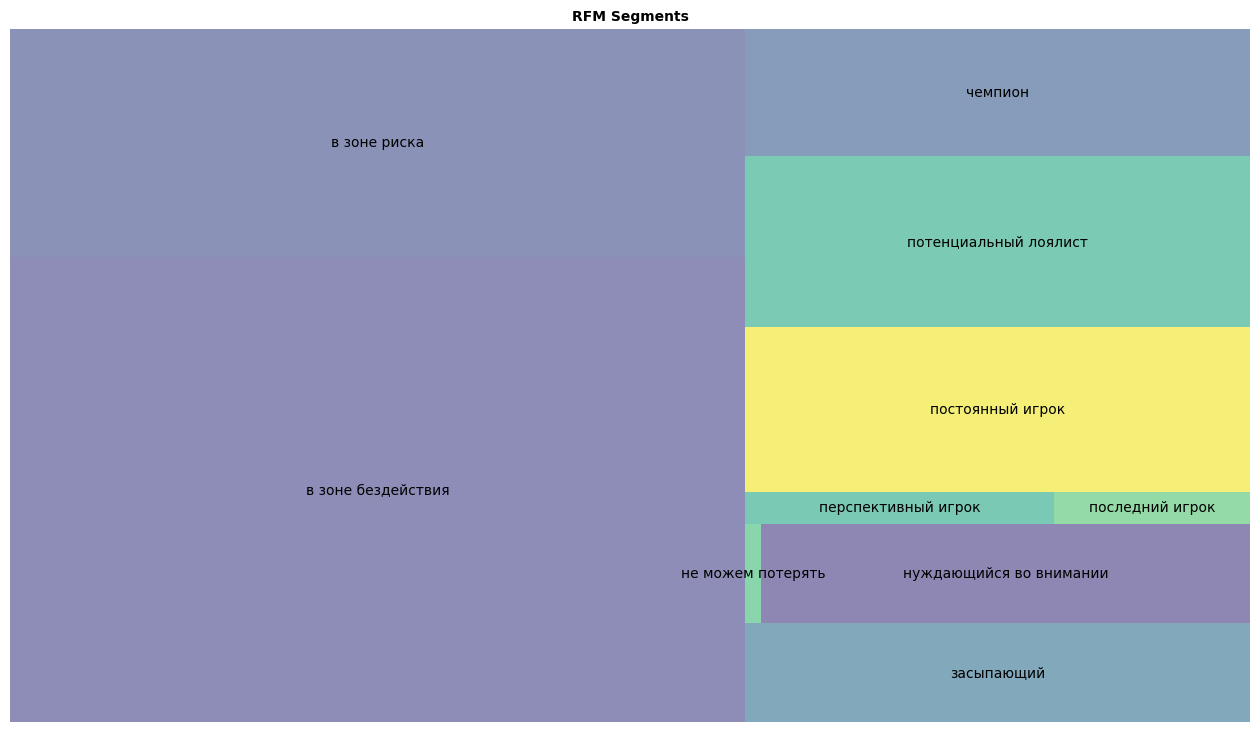

In [113]:
fig = plt.gcf()
ax = fig.add_subplot()
labels = rfm_level_agg.index.values
fig.set_size_inches(16, 9)
squarify.plot(sizes=rfm_level_agg['Кол-во_чел'],label=labels, alpha=.6 )
plt.title("RFM Segments",fontsize=10,fontweight="bold")
plt.axis('off')
plt.show()

## ABC анализ по числу подписчиков

In [114]:
df_abc_f = df_rfm.copy(deep=True)

In [115]:
# заполним пропуски, преобразуем тип данных
df_abc_f['title'] = df_abc_f['title'].fillna(value='inactive')
df_abc_f['is_streamer'] = df_abc_f['is_streamer'].fillna(value='inactive')
df_abc_f['followers'] = df_abc_f['followers'].fillna(value=0)
df_abc_f['followers'] = df_abc_f['followers'].astype(int)
df_abc_f

username title                          tournament_name  \
0                andrzej    CM  Late-Titled-Tuesday-Blitz-March-05-2024   
1                    gmg    GM  Late-Titled-Tuesday-Blitz-March-05-2024   
2          ukchessbomber    FM  Late-Titled-Tuesday-Blitz-March-05-2024   
3       danielnaroditsky    GM  Late-Titled-Tuesday-Blitz-March-05-2024   
4        musiccitymaster    FM  Late-Titled-Tuesday-Blitz-March-05-2024   
...                  ...   ...                                      ...   
174057             pomoc   WGM             *** Titled Tuesday 3|2 Blitz   
174058      underdogchss    GM             *** Titled Tuesday 3|2 Blitz   
174059        angry_serb    IM             *** Titled Tuesday 3|2 Blitz   
174060           usurpov    FM             *** Titled Tuesday 3|2 Blitz   
174061   alex_stripunsky    GM             *** Titled Tuesday 3|2 Blitz   

       tournament_id                   game_id          start_time  \
0            4605130           andrzej-4605130 2024-03-05 22:00:00   
1            4605130               gmg-4605130 2024-03-05 22:00:00   
2            4605130     ukchessbomber-4605130 2024-03-05 22:00:00   
3            4605130  danielnaroditsky-4605130 2024-03-05 22:00:00   
4            4605130   musiccitymaster-4605130 2024-03-05 22:00:00   
...              ...                       ...                 ...   
174057        646318              pomoc-646318 2016-04-05 18:00:00   
174058        646318       underdogchss-646318 2016-04-05 18:00:00   
174059        646318         angry_serb-646318 2016-04-05 18:00:00   
174060        646318            usurpov-646318 2016-04-05 18:00:00   
174061        646318    alex_stripunsky-646318 2016-04-05 18:00:00   

               finish_time  games_count  registered_user_count game_quarter  \
0      2024-03-06 00:06:07           11                    502       2024Q1   
1      2024-03-06 00:06:07           11                    502       2024Q1   
2      2024-03-06 00:06:07           11                    502       2024Q1   
3      2024-03-06 00:06:07           11                    502       2024Q1   
4      2024-03-06 00:06:07           11                    502       2024Q1   
...                    ...          ...                    ...          ...   
174057 2016-04-05 18:13:36            9                    123       2016Q2   
174058 2016-04-05 18:13:36            9                    123       2016Q2   
174059 2016-04-05 18:13:36            9                    123       2016Q2   
174060 2016-04-05 18:13:36            9                    123       2016Q2   
174061 2016-04-05 18:13:36            9                    123       2016Q2   

       cohort_quarter  cohort_index is_streamer  followers   status country  \
0              2018Q3            22       False        135  premium      PL   
1              2016Q2            31       False       2751  premium      US   
2              2020Q4            13       False        117  premium      XE   
3              2016Q2            31        True      28748  premium      US   
4              2019Q3            18       False        445  premium      US   
...               ...           ...         ...        ...      ...     ...   
174057         2016Q2             0       False         87  premium      HU   
174058         2016Q2             0       False         55  premium      ZA   
174059         2016Q2             0       False        143  premium      RS   
174060         2016Q2             0       False        306  premium      AR   
174061         2016Q2             0       False         57  premium      US   

        total_input  
0                11  
1                11  
2                11  
3                11  
4                11  
...             ...  
174057            9  
174058            9  
174059            9  
174060            9  
174061            9  

[174062 rows x 17 columns]

In [116]:
df_abc_f.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174062 entries, 0 to 174061
Data columns (total 17 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   username               174062 non-null  object        
 1   title                  174062 non-null  object        
 2   tournament_name        174062 non-null  object        
 3   tournament_id          174062 non-null  object        
 4   game_id                174062 non-null  object        
 5   start_time             174062 non-null  datetime64[ns]
 6   finish_time            174062 non-null  datetime64[ns]
 7   games_count            174062 non-null  int64         
 8   registered_user_count  174062 non-null  int64         
 9   game_quarter           174062 non-null  period[Q-DEC] 
 10  cohort_quarter         174062 non-null  period[Q-DEC] 
 11  cohort_index           174062 non-null  int64         
 12  is_streamer            174062 non-null  obje

In [117]:
# подсчитаем число подписчиков у каждого шахматиста
followers = df_abc_f.groupby(['username', 'title', 'is_streamer'])['followers'].unique()
followers.sort_values(ascending=False)

username        title     is_streamer
hikaru          GM        True           [1191274]
danielrensch    IM        True            [434082]
magnuscarlsen   GM        False           [185912]
gothamchess     IM        True             [92187]
alexandrabotez  WFM       True             [67284]
                                           ...    
mukhin1         inactive  inactive             [0]
muguet7         inactive  inactive             [0]
mrvezunchik     inactive  inactive             [0]
mrtravmatolog   IM        False                [0]
zzzombie        inactive  inactive             [0]
Name: followers, Length: 7556, dtype: object

In [118]:
# создадим отдельный датафрейм из Series: игроки, титул, статус стримера, число подписчиков
df_followers = followers.to_frame()
df_followers = df_followers.reset_index()
df_followers['followers'] = df_followers['followers'].astype(int)
df_followers['is_streamer']=df_followers['is_streamer'].astype(str)
df_followers


username     title is_streamer  followers
0              017290        FM       False          0
1             01roman        FM       False         25
2            03revilo        FM       False         22
3        0815original        FM       False         15
4            0gzpanda        IM       False        381
...               ...       ...         ...        ...
7551  zvonokchess1996        GM       False        199
7552   zwischenzugged  inactive    inactive          0
7553            zzoom        NM       False        282
7554           zzww18        NM       False         22
7555         zzzombie  inactive    inactive          0

[7556 rows x 4 columns]

In [119]:
total_followers = df_followers['followers'].sum()
total_followers

4013558

In [120]:
# Сгруппируем число подписчиков у различных категорий игроков
# followers_sum = df_abc_f.groupby(['title','is_streamer'])['total_followers'].sum().sort_values(ascending=False)
followers_input = df_followers.groupby(['title','is_streamer'])['followers'].sum().sort_values(ascending=False)
followers_input = followers_input.reset_index()
followers_input


title is_streamer  followers
0         GM        True    1584596
1         GM       False     698523
2         IM        True     560309
3         FM       False     265423
4         IM       False     247270
5         NM       False     165541
6        WFM        True     115357
7         CM       False      90929
8         NM        True      69950
9         FM        True      56144
10       WGM       False      31875
11       WIM       False      26899
12       WFM       False      26235
13       WGM        True      22678
14        CM        True      15657
15       WIM        True      14052
16       WCM       False      11732
17       WCM        True      10262
18       WNM       False        126
19  inactive    inactive          0

In [121]:
followers_input = followers_input.drop(followers_input[followers_input['title']=='inactive'].index)
followers_input;

In [122]:
# Рассчитаем кумулятивную сумму в процентах
followers_input['cumulative_followers'] = followers_input['followers'].cumsum()
followers_input['cumulative_percentage'] = 100 * followers_input['cumulative_followers'] / total_followers
followers_input

title is_streamer  followers  cumulative_followers  cumulative_percentage
0     GM        True    1584596               1584596              39.481079
1     GM       False     698523               2283119              56.885163
2     IM        True     560309               2843428              70.845569
3     FM       False     265423               3108851              77.458729
4     IM       False     247270               3356121              83.619596
5     NM       False     165541               3521662              87.744141
6    WFM        True     115357               3637019              90.618324
7     CM       False      90929               3727948              92.883870
8     NM        True      69950               3797898              94.626713
9     FM        True      56144               3854042              96.025571
10   WGM       False      31875               3885917              96.819754
11   WIM       False      26899               3912816              97.489958
12   WFM       False      26235               3939051              98.143617
13   WGM        True      22678               3961729              98.708652
14    CM        True      15657               3977386              99.098755
15   WIM        True      14052               3991438              99.448868
16   WCM       False      11732               4003170              99.741177
17   WCM        True      10262               4013432              99.996861
18   WNM       False        126               4013558             100.000000

In [123]:
#Присваиваем категории
followers_input['ABC_CATEGORY'] = 'C' # по умолчанию - С
followers_input.loc[followers_input['cumulative_percentage'] <= 80, 'ABC_CATEGORY'] = 'A'
followers_input.loc[(followers_input['cumulative_percentage'] > 80) & (followers_input['cumulative_percentage'] <= 95), 'ABC_CATEGORY'] = 'B'

In [124]:
# Смотрим на результаты сегментации
abc_analysis_result = followers_input[['title','is_streamer', 'followers', 'cumulative_percentage', 'ABC_CATEGORY']]
abc_analysis_result

title is_streamer  followers  cumulative_percentage ABC_CATEGORY
0     GM        True    1584596              39.481079            A
1     GM       False     698523              56.885163            A
2     IM        True     560309              70.845569            A
3     FM       False     265423              77.458729            A
4     IM       False     247270              83.619596            B
5     NM       False     165541              87.744141            B
6    WFM        True     115357              90.618324            B
7     CM       False      90929              92.883870            B
8     NM        True      69950              94.626713            B
9     FM        True      56144              96.025571            C
10   WGM       False      31875              96.819754            C
11   WIM       False      26899              97.489958            C
12   WFM       False      26235              98.143617            C
13   WGM        True      22678              98.708652            C
14    CM        True      15657              99.098755            C
15   WIM        True      14052              99.448868            C
16   WCM       False      11732              99.741177            C
17   WCM        True      10262              99.996861            C
18   WNM       False        126             100.000000            C

In [125]:
# выведем топ игроков, которых можно привлекать на платформу в качестве стримера
df_followers[(df_followers['title'].isin(['GM','FM']))&(df_followers['is_streamer']=='False')].sort_values(by='followers', ascending=False).head(20)

username title is_streamer  followers
4232       magnuscarlsen    GM       False     185912
2354        firouzja2003    GM       False      21491
2252      fabianocaruana    GM       False      16639
310        alexsuper1987    FM       False      10132
2715               gmwso    GM       False       9414
479            anishgiri    GM       False       9296
2650          gm_dmitrij    GM       False       8930
7257         white_ghost    FM       False       8282
1099            byniolus    GM       False       7698
5313          penguingm1    GM       False       7637
5430  polish_fighter3000    GM       False       7240
2802            grischuk    GM       False       7049
4977       nikotheodorou    GM       False       6947
1980             duhless    GM       False       6892
5830          rpragchess    GM       False       6739
4038              liemle    GM       False       6376
1432         chopper1905    GM       False       6206
4021        levonaronian    GM       False       5690
480       anishonyoutube    GM       False       5394
4580          mikasinski    FM       False       5166

In [126]:
# топы стримеров
df_followers[(df_followers['title'].isin(['GM','FM']))&(df_followers['is_streamer']=='True')].sort_values(by='followers', ascending=False).head(20)

username title is_streamer  followers
2971              hikaru    GM        True    1191274
2610           ginger_gm    GM        True      56126
2680              gmhess    GM        True      34880
2686            gmkrikor    GM        True      29787
1638    danielnaroditsky    GM        True      28748
4156          luisfsiles    FM        True      23127
1298           chessbrah    GM        True      22944
3461              jospem    GM        True      20823
2665  gmbenjaminfinegold    GM        True      18919
2900              hansen    GM        True      14502
4957          nihalsarin    GM        True      14362
7095          viditchess    GM        True      13814
3770                knvb    GM        True      12511
4183           lyonbeast    GM        True      11833
3899           lachesisq    GM        True      11066
2664       gmbenjaminbok    GM        True      10470
5114   oleksandr_bortnyk    GM        True       8985
4131              lpsupi    GM        True       8660
2666             gmcanty    FM        True       8307
2697            gmrafpig    GM        True       5947

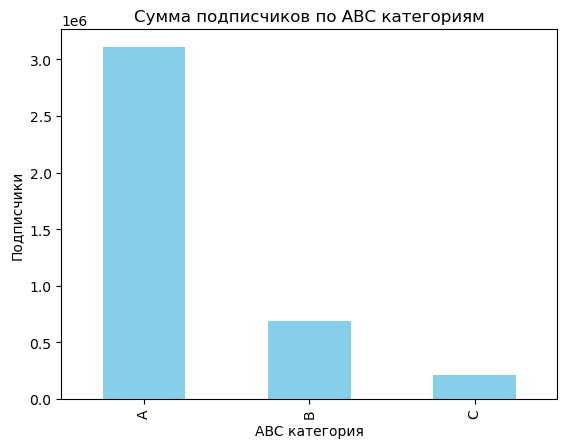

In [127]:
# Подготовка данных
bar_chart_data = followers_input.groupby('ABC_CATEGORY')['followers'].sum()

# Создаем столбчатую диаграмму
bar_chart_data.plot(kind='bar', color='skyblue')
plt.title('Сумма подписчиков по ABС категориям')
plt.xlabel('ABC категория')
plt.ylabel('Подписчики')
plt.show()

## XYZ анализ по подписчикам

In [128]:
# Рассчитываем среднюю и стандартное отклонение кол-ва подписчиков для каждой категории игроков
# followers_stats = df_followers.groupby('title')['followers'].agg(['mean', 'std']).reset_index()
# followers_stats

In [129]:
# Рассчитываем коэффициент вариации
# followers_stats['Coefficient of Variation'] = followers_stats['std'] / followers_stats['mean']
# followers_stats = followers_stats.dropna()
# followers_stats

In [130]:
# Присваиваем XYZ категории
# Категоризация может быть довольно субъективной, однако это самый распространенный способ разделения :
# X: CV <= 0.5 (стабильный спрос)
# Y: 0.5 < CV <= 1.0 (средняя волатильность спроса)
# Z: CV > 1.0 (высокая волатильность)
# followers_stats['XYZ Category'] = 'Z' # по умолчанию - Z
# followers_stats.loc[followers_stats['Coefficient of Variation'] <= 0.5, 'XYZ Category'] = 'X'
# followers_stats.loc[(followers_stats['Coefficient of Variation'] > 0.5) & (followers_stats['Coefficient of Variation'] <= 1.0), 'XYZ Category'] = 'Y'

In [131]:
# xyz_analysis_result = followers_stats[['title', 'Coefficient of Variation', 'XYZ Category']]
# xyz_analysis_result

In [132]:
# combined_analysis = pd.merge(abc_g_analysis_result, xyz_analysis_result, on='title')
# combined_analysis

In [133]:
# category_mapping = {'A': 1, 'B': 2, 'C': 3, 'X': 1, 'Y': 2, 'Z': 3}
# combined_analysis['ABC Numeric'] = combined_analysis['ABC_CATEGORY'].map(category_mapping)
# combined_analysis['XYZ Numeric'] = combined_analysis['XYZ Category'].map(category_mapping)

# plt.figure(figsize=(10, 6))
# sns.scatterplot(data=combined_analysis, x='Coefficient of Variation', y='ABC Numeric', hue='XYZ Category', 
#                 style='ABC_CATEGORY', s=100)

# plt.title('ABC-XYZ Анализ')
# plt.xlabel('Коэффициент вариации (XYZ)')
# plt.ylabel('ABC Категория')
# plt.yticks([1, 2, 3], ['A', 'B', 'C'])
# plt.grid(True)
# plt.legend(title='XYZ Category', bbox_to_anchor=(1.05, 1), loc='upper left')

# plt.show()

## ABC анализ по числу игр: самые играющие категории

In [134]:
df_abc_g = df_rfm.copy(deep=True)

In [135]:
df_abc_g

username title                          tournament_name  \
0                andrzej    CM  Late-Titled-Tuesday-Blitz-March-05-2024   
1                    gmg    GM  Late-Titled-Tuesday-Blitz-March-05-2024   
2          ukchessbomber    FM  Late-Titled-Tuesday-Blitz-March-05-2024   
3       danielnaroditsky    GM  Late-Titled-Tuesday-Blitz-March-05-2024   
4        musiccitymaster    FM  Late-Titled-Tuesday-Blitz-March-05-2024   
...                  ...   ...                                      ...   
174057             pomoc   WGM             *** Titled Tuesday 3|2 Blitz   
174058      underdogchss    GM             *** Titled Tuesday 3|2 Blitz   
174059        angry_serb    IM             *** Titled Tuesday 3|2 Blitz   
174060           usurpov    FM             *** Titled Tuesday 3|2 Blitz   
174061   alex_stripunsky    GM             *** Titled Tuesday 3|2 Blitz   

       tournament_id                   game_id          start_time  \
0            4605130           andrzej-4605130 2024-03-05 22:00:00   
1            4605130               gmg-4605130 2024-03-05 22:00:00   
2            4605130     ukchessbomber-4605130 2024-03-05 22:00:00   
3            4605130  danielnaroditsky-4605130 2024-03-05 22:00:00   
4            4605130   musiccitymaster-4605130 2024-03-05 22:00:00   
...              ...                       ...                 ...   
174057        646318              pomoc-646318 2016-04-05 18:00:00   
174058        646318       underdogchss-646318 2016-04-05 18:00:00   
174059        646318         angry_serb-646318 2016-04-05 18:00:00   
174060        646318            usurpov-646318 2016-04-05 18:00:00   
174061        646318    alex_stripunsky-646318 2016-04-05 18:00:00   

               finish_time  games_count  registered_user_count game_quarter  \
0      2024-03-06 00:06:07           11                    502       2024Q1   
1      2024-03-06 00:06:07           11                    502       2024Q1   
2      2024-03-06 00:06:07           11                    502       2024Q1   
3      2024-03-06 00:06:07           11                    502       2024Q1   
4      2024-03-06 00:06:07           11                    502       2024Q1   
...                    ...          ...                    ...          ...   
174057 2016-04-05 18:13:36            9                    123       2016Q2   
174058 2016-04-05 18:13:36            9                    123       2016Q2   
174059 2016-04-05 18:13:36            9                    123       2016Q2   
174060 2016-04-05 18:13:36            9                    123       2016Q2   
174061 2016-04-05 18:13:36            9                    123       2016Q2   

       cohort_quarter  cohort_index is_streamer  followers   status country  \
0              2018Q3            22       False      135.0  premium      PL   
1              2016Q2            31       False     2751.0  premium      US   
2              2020Q4            13       False      117.0  premium      XE   
3              2016Q2            31        True    28748.0  premium      US   
4              2019Q3            18       False      445.0  premium      US   
...               ...           ...         ...        ...      ...     ...   
174057         2016Q2             0       False       87.0  premium      HU   
174058         2016Q2             0       False       55.0  premium      ZA   
174059         2016Q2             0       False      143.0  premium      RS   
174060         2016Q2             0       False      306.0  premium      AR   
174061         2016Q2             0       False       57.0  premium      US   

        total_input  
0                11  
1                11  
2                11  
3                11  
4                11  
...             ...  
174057            9  
174058            9  
174059            9  
174060            9  
174061            9  

[174062 rows x 17 columns]

In [136]:
df_abc_g['title'] = df_abc_g['title'].fillna(value='inactive')
df_abc_g['is_streamer'] = df_abc_g['is_streamer'].fillna(value='inactive')

In [137]:
df_abc_g

username title                          tournament_name  \
0                andrzej    CM  Late-Titled-Tuesday-Blitz-March-05-2024   
1                    gmg    GM  Late-Titled-Tuesday-Blitz-March-05-2024   
2          ukchessbomber    FM  Late-Titled-Tuesday-Blitz-March-05-2024   
3       danielnaroditsky    GM  Late-Titled-Tuesday-Blitz-March-05-2024   
4        musiccitymaster    FM  Late-Titled-Tuesday-Blitz-March-05-2024   
...                  ...   ...                                      ...   
174057             pomoc   WGM             *** Titled Tuesday 3|2 Blitz   
174058      underdogchss    GM             *** Titled Tuesday 3|2 Blitz   
174059        angry_serb    IM             *** Titled Tuesday 3|2 Blitz   
174060           usurpov    FM             *** Titled Tuesday 3|2 Blitz   
174061   alex_stripunsky    GM             *** Titled Tuesday 3|2 Blitz   

       tournament_id                   game_id          start_time  \
0            4605130           andrzej-4605130 2024-03-05 22:00:00   
1            4605130               gmg-4605130 2024-03-05 22:00:00   
2            4605130     ukchessbomber-4605130 2024-03-05 22:00:00   
3            4605130  danielnaroditsky-4605130 2024-03-05 22:00:00   
4            4605130   musiccitymaster-4605130 2024-03-05 22:00:00   
...              ...                       ...                 ...   
174057        646318              pomoc-646318 2016-04-05 18:00:00   
174058        646318       underdogchss-646318 2016-04-05 18:00:00   
174059        646318         angry_serb-646318 2016-04-05 18:00:00   
174060        646318            usurpov-646318 2016-04-05 18:00:00   
174061        646318    alex_stripunsky-646318 2016-04-05 18:00:00   

               finish_time  games_count  registered_user_count game_quarter  \
0      2024-03-06 00:06:07           11                    502       2024Q1   
1      2024-03-06 00:06:07           11                    502       2024Q1   
2      2024-03-06 00:06:07           11                    502       2024Q1   
3      2024-03-06 00:06:07           11                    502       2024Q1   
4      2024-03-06 00:06:07           11                    502       2024Q1   
...                    ...          ...                    ...          ...   
174057 2016-04-05 18:13:36            9                    123       2016Q2   
174058 2016-04-05 18:13:36            9                    123       2016Q2   
174059 2016-04-05 18:13:36            9                    123       2016Q2   
174060 2016-04-05 18:13:36            9                    123       2016Q2   
174061 2016-04-05 18:13:36            9                    123       2016Q2   

       cohort_quarter  cohort_index is_streamer  followers   status country  \
0              2018Q3            22       False      135.0  premium      PL   
1              2016Q2            31       False     2751.0  premium      US   
2              2020Q4            13       False      117.0  premium      XE   
3              2016Q2            31        True    28748.0  premium      US   
4              2019Q3            18       False      445.0  premium      US   
...               ...           ...         ...        ...      ...     ...   
174057         2016Q2             0       False       87.0  premium      HU   
174058         2016Q2             0       False       55.0  premium      ZA   
174059         2016Q2             0       False      143.0  premium      RS   
174060         2016Q2             0       False      306.0  premium      AR   
174061         2016Q2             0       False       57.0  premium      US   

        total_input  
0                11  
1                11  
2                11  
3                11  
4                11  
...             ...  
174057            9  
174058            9  
174059            9  
174060            9  
174061            9  

[174062 rows x 17 columns]

In [138]:
df_abc_g['total_games'] = df_abc_g['games_count']
total_games = df_abc_g['total_games'].sum()
total_games

1866844

In [139]:
# Сгруппируем число игр по категориям игроков
games_input = df_abc_g.groupby(['title','is_streamer'])['total_games'].sum().sort_values(ascending=False)
games_input = games_input.reset_index()
games_input

title is_streamer  total_games
0         FM       False       550076
1         IM       False       333971
2         GM       False       299483
3         NM       False       207806
4         CM       False       184520
5   inactive    inactive        55845
6         GM        True        54462
7        WFM       False        52530
8        WIM       False        35870
9        WGM       False        21290
10       WCM       False        19201
11        IM        True        13876
12        FM        True        11789
13        NM        True        10717
14       WFM        True         6262
15       WGM        True         4413
16       WIM        True         1633
17       WCM        True         1239
18        CM        True         1014
19       WNM       False          847

In [140]:
# Рассчитаем куммулятивную сумму в процентах
games_input['cumulative_games'] = games_input['total_games'].cumsum()
games_input['cumulative_percentage'] = 100 * games_input['cumulative_games'] / total_games
games_input

title is_streamer  total_games  cumulative_games  cumulative_percentage
0         FM       False       550076            550076              29.465558
1         IM       False       333971            884047              47.355162
2         GM       False       299483           1183530              63.397370
3         NM       False       207806           1391336              74.528777
4         CM       False       184520           1575856              84.412838
5   inactive    inactive        55845           1631701              87.404250
6         GM        True        54462           1686163              90.321580
7        WFM       False        52530           1738693              93.135420
8        WIM       False        35870           1774563              95.056845
9        WGM       False        21290           1795853              96.197272
10       WCM       False        19201           1815054              97.225799
11        IM        True        13876           1828930              97.969086
12        FM        True        11789           1840719              98.600579
13        NM        True        10717           1851436              99.174650
14       WFM        True         6262           1857698              99.510082
15       WGM        True         4413           1862111              99.746471
16       WIM        True         1633           1863744              99.833944
17       WCM        True         1239           1864983              99.900313
18        CM        True         1014           1865997              99.954629
19       WNM       False          847           1866844             100.000000

In [141]:
#Присваиваем категории
games_input['ABC_CATEGORY'] = 'C' # по умолчанию - С
games_input.loc[games_input['cumulative_percentage'] <= 80, 'ABC_CATEGORY'] = 'A'
games_input.loc[(games_input['cumulative_percentage'] > 80) & (games_input['cumulative_percentage'] <= 95), 'ABC_CATEGORY'] = 'B'

In [142]:
# Смотрим на результаты сегментации
abc_g_analysis_result = games_input[['title','is_streamer', 'total_games', 'cumulative_percentage', 'ABC_CATEGORY']]
abc_g_analysis_result

title is_streamer  total_games  cumulative_percentage ABC_CATEGORY
0         FM       False       550076              29.465558            A
1         IM       False       333971              47.355162            A
2         GM       False       299483              63.397370            A
3         NM       False       207806              74.528777            A
4         CM       False       184520              84.412838            B
5   inactive    inactive        55845              87.404250            B
6         GM        True        54462              90.321580            B
7        WFM       False        52530              93.135420            B
8        WIM       False        35870              95.056845            C
9        WGM       False        21290              96.197272            C
10       WCM       False        19201              97.225799            C
11        IM        True        13876              97.969086            C
12        FM        True        11789              98.600579            C
13        NM        True        10717              99.174650            C
14       WFM        True         6262              99.510082            C
15       WGM        True         4413              99.746471            C
16       WIM        True         1633              99.833944            C
17       WCM        True         1239              99.900313            C
18        CM        True         1014              99.954629            C
19       WNM       False          847             100.000000            C

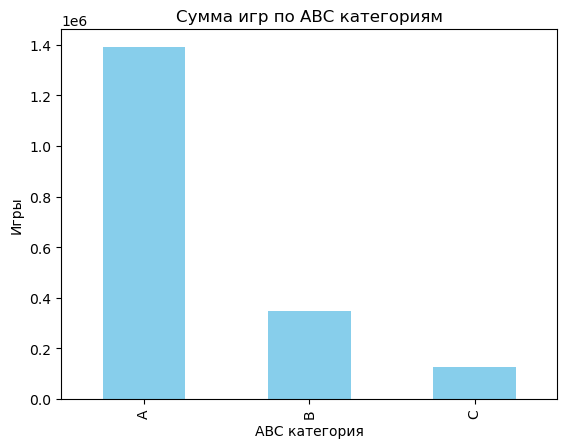

In [143]:
# Подготовка данных
bar_chart_data = games_input.groupby('ABC_CATEGORY')['total_games'].sum()

# Создаем столбчатую диаграмму
bar_chart_data.plot(kind='bar', color='skyblue')
plt.title('Сумма игр по ABС категориям')
plt.xlabel('ABC категория')
plt.ylabel('Игры')
plt.show()

## Выводы:
#### 1. RFM анализ позволил определить категории игроков на турнире Titled Tuesday по критерию активности, а именно по давности игры (R), числу проведенных турниров (F) и игр (M).
За все время турнира в нем приняло участие 7543 шахматситов. 
Наиболее активные игроки попали в раздел "чемпион", "постоянный игрок" - их 595 и 720 человек соотвественно.
Еще 788 шахматистов могут перейти в эти категории, если сохранят сложившийся тренд.
Платформе Chess.com следует уделить дополнительное внимание шахматистам категорий зоны риска: у них довольно высокое число игр и турниров, однако их активность снижается. 
Почти половина исследуемых игроков, 2978 человек, находятся в бездействии. Платформе стоит предпринять меры по возвращению их в игру..
#### 2. ABC анализ помог разделить категории игроков на сегменты по принципу числа подписчиков. 
Наибольший вклад в популяризацию платформы и шахмат вносят игроки категорий GM и IM со статусом стримера - сегмент A. На них приходится более 2 млн подпсичиков.
Также в сегменте A есть игроки, не являющиеся стримерами, но имеющие порядка 950 тыс. подписчиков, которые следят за результатами их игр и прочей активностью.
Вероятно, некоторые из них уже ведут трансляции на других платформах, однако платформе Chess.com стоит рассмотреть с ними сотрудничество для привлечения на свой стриминговый сервис. 
Топ таких игроков: firouzja2003[GM], fabianocaruana[GM], alexsuper1987[FM], gmwso[GM], anishgiri[GM], gm_dmitrij[GM], white_ghost[FM]
#### 3. ABC анализ по числу игр: самые играющие категории
Наибольшую активность проявляют шахматисты категорий FM, IM, GM, NM не являющиеся стримерами: они больше всего играют.

Наименьшую активность показывают игроки категорий WCM, WNM, CM это национальные мастеры и КМС. Причина в их малой численности, и высокой конкуренции в турнире TT.
